In [1]:
# Para que las funciones se actualicen sin tener que refrescar el kernel
%load_ext autoreload
%autoreload 2

import pandas as pd
import json
from os.path import exists
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress as LR
from scipy.stats import skew, kurtosis, skewtest, kurtosistest

# Funciones propias
from utils_limpieza import * 

In [2]:
# Cargar datos
path = '../data/raw/tp2_muestra_diplodatos_ventas_omega_modelo_2023.csv'
ventas = pd.read_csv(path)


/tmp/ipykernel_124938/3921706967.py:3: DtypeWarning: Columns (10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  ventas = pd.read_csv(path)


## Hacemos la limpieza sugerida al principio del TP2
- [x] Eliminar las variables en `cols_dropear` (Paso 1).
- [x] Renombrar a 'Otros' las subcategorías que no tengan `MODELO` (Paso 2).
- [x] Se eliminan los registros en 'Otros'. Previamente se almacenan en un dataset aparte.

In [3]:
print(f'El df original tiene {ventas.shape[0]} registros y {ventas.shape[1]} variables.\n')

# Paso 1
cols_dropear = ['INSCRIPCION', 'CATEGORIA', 'DESCRIPCION_CATEGORIA', 'CATEGORIA (Ajustado)', 'NOMBRE']
ventas_renamed = limpiar_basic(ventas, cols_drop=cols_dropear)
print(f'Luego del paso 1 se tiran {len(cols_dropear)} variables, quedando {ventas_renamed.shape[1]} variables.\n')

# Paso 2
# ventas_renamed['SUB-CATEGORIA'].nunique() # antes del paso 2
ventas_renamed = renombrar_elementos(ventas_renamed, 
                                     columna='SUB-CATEGORIA', 
                                     fill_otros='Otros')

scu_vr = ventas_renamed['SUB-CATEGORIA'].nunique()
scu_ot = ventas_renamed['SUB-CATEGORIA'].nunique() - scu_vr + 1
print(f'Luego del paso 2 quedan {scu_vr} subcategorías únicas.')
print(f'Las {scu_ot} subcategorías únicas que no tenían ningún vendedor modelo fueron agrupadas en "Otros".')
print(f'Las {scu_vr-1} subcategorías que sí tienen vendedores modelo son:')

ventas_renamed.groupby(by=['SUB-CATEGORIA'])['MODELO'].sum().sort_values(ascending=False)[:12]

El df original tiene 435489 registros y 19 variables.

Luego del paso 1 se tiran 5 variables, quedando 14 variables.

Luego del paso 2 quedan 13 subcategorías únicas.
Las 1 subcategorías únicas que no tenían ningún vendedor modelo fueron agrupadas en "Otros".
Las 12 subcategorías que sí tienen vendedores modelo son:


SUB-CATEGORIA
Venta de Artículos, productos, accesorios, etc de diversos materiales      1902
Venta de Combustibles (Incluye tmb gas, carbón, leña, etc)                  951
Venta de Productos Alimenticios, Bebidas, Lácteos y afines                  586
Venta de Productos farmacéuticos, de perfumería, cosméticos y similares     420
Venta de Combustibles Ley 23966 (Incluye tmb gas, carbón, leña, etc)        394
Venta en Comisión, Consignación o Intermediación de Productos Varios        336
Cigarrillos, tabacos y afines                                               282
Supermercados, Hipermercados, Kioscos y afines                              156
Venta de Combustibles para reventa (Incluye tmb gas, carbón, leña, etc)     131
Venta de Autos, Camionetas, Motos, y Afines                                 126
Venta de Semillas, Fertilizantes, Granos y afines                            84
Instalación, Mantenimiento, Reparación, etc de productos varios               6
Name: MODELO, dtype: int64

In [4]:
#Eliminación de registros en "Otros" y almacenamiento en un dataset aparte

ventas_otros = ventas_renamed[ventas_renamed['SUB-CATEGORIA'] == 'Otros'].copy()
ventas_otros.to_csv('../data/interim/tp2_ventas_otros.csv')

ventas_renamed = ventas_renamed[ventas_renamed['SUB-CATEGORIA'] != 'Otros'].copy()

## Análisis de datos faltantes
- [x] Chequear presencia de datos faltantes
- [x] Analizar su correlación
- [x] Imputar de valores faltantes: `CM` y `Trat_Dif` con 'No'.

Faltan datos en las mismas variables que antes. Imputo los complementos en `CM` y `Trat_Dif` para dejarlas listas. Luego de eso, se cumple lo que ya habíamos visto en el tp1.

In [5]:
ventas_renamed.columns

Index(['ID_VENDEDOR', 'AÑO', 'MES', 'DEPOSITO', 'TOTAL_VENTAS',
       'PORCENTAJE_COMISION_EMPRESA', 'COMISION_EMPRESA', 'TRATAMIENTO_FISCAL',
       'DESC_TRATAMIENTO_FISCAL', 'TRATAMIENTO_DIFERNCIAL', 'CM04',
       'SUB-CATEGORIA', 'OMEGA', 'MODELO'],
      dtype='object')

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

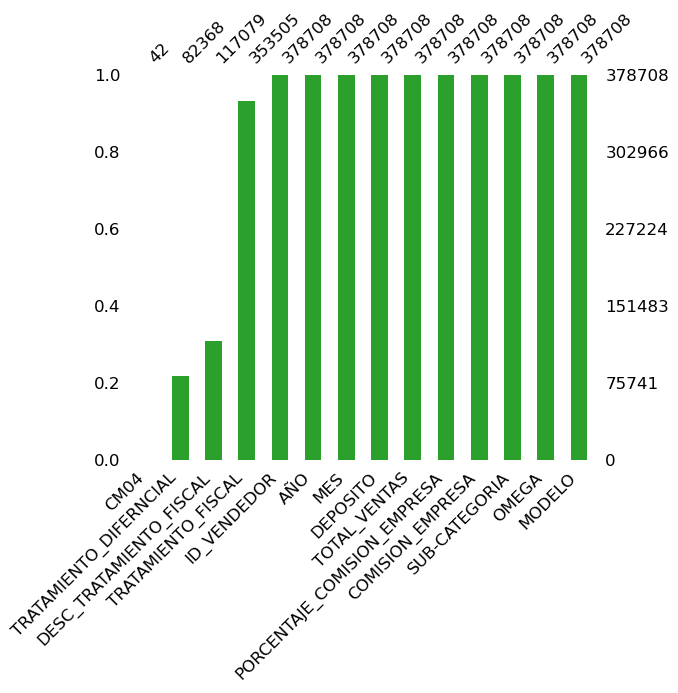

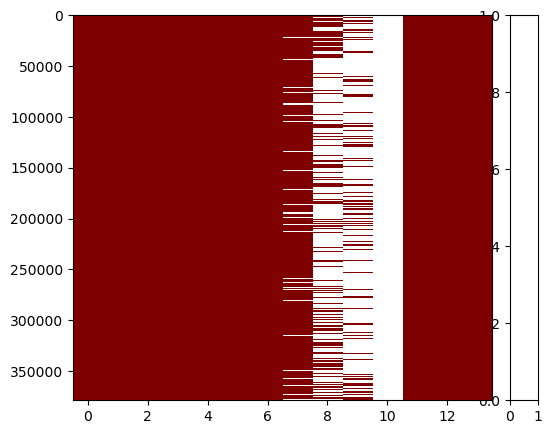

In [6]:
msno.bar(ventas_renamed.sort_values('ID_VENDEDOR'), sort="ascending", fontsize=12, color="tab:green", figsize=(6, 5))
msno.matrix(ventas_renamed.sort_values('ID_VENDEDOR'), fontsize=12, color=[0.5,0,0], figsize=(6, 5))
msno.heatmap(ventas_renamed.sort_values('ID_VENDEDOR'), fontsize=12, figsize=(6, 5))

plt.show()

In [7]:
ventas_renamed['CM04'] = ventas_renamed['CM04'].fillna('No')
ventas_renamed['TRATAMIENTO_DIFERNCIAL'] = ventas_renamed['TRATAMIENTO_DIFERNCIAL'].fillna('No')

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

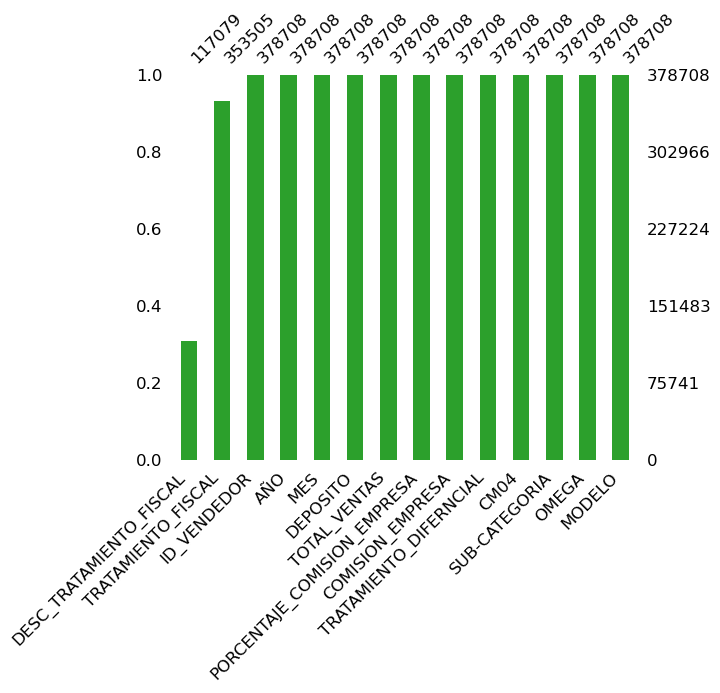

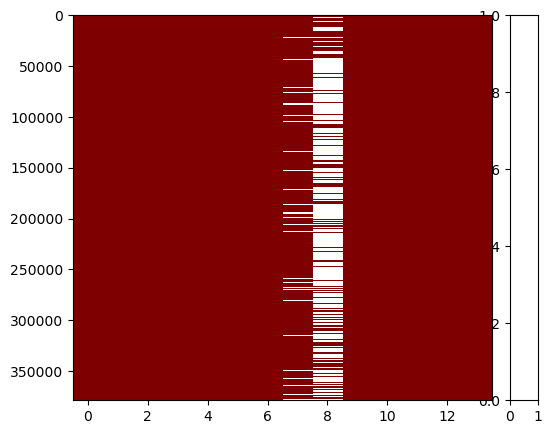

In [8]:
msno.bar(ventas_renamed.sort_values('ID_VENDEDOR'), sort="ascending", fontsize=12, color="tab:green", figsize=(6, 5))
msno.matrix(ventas_renamed.sort_values('ID_VENDEDOR'), fontsize=12, color=[0.5,0,0], figsize=(6, 5))
msno.heatmap(ventas_renamed.sort_values('ID_VENDEDOR'), fontsize=12, figsize=(6, 5))

plt.show()

## Anonimizado + simplificación de variables y valores
- [x] Simplificamos el nombre de las variables.
- [x] Anonimizamos la variable sensible `ID` (Paso 3).
- [x] Simplificamos (podría decir acá también que anonimizamos?) valores en `Deposito`
- [x] Unificación y simplificación de categorías de `Trat_Fisc`.
- [x] Simplificación de categorías de `Trat_Fisc_Agg` y `Trat_Dif`.
- [x] Simplificación de categorías en `Categoria`.
- [x] Guardamos todos estos diccionarios.
- [x] CM: de Si/No a 1/0.

In [9]:
# Se modifican los nombres de las columnas

# Renombramos
with open("../references/tp2_column_dict.json") as column_dict_json:
    column_dict = json.load(column_dict_json)

ventas_renamed.rename(columns = column_dict, inplace = True)
ventas_renamed.columns

Index(['ID', 'Año', 'Mes', 'Deposito', 'Ventas', 'Alicuota', 'Comision',
       'Trat_Fisc', 'Trat_Fisc_Agg', 'Trat_Dif', 'CM', 'Subrubro', 'Omega',
       'Modelo'],
      dtype='object')

In [10]:
# Anonimizamos y guardamos el diccionario para no perder esta info
ventas_hash, dict_id = anonimizar(ventas_renamed, 'ID')

with open("../references/tp2_ID_dict.json", "w") as fp:
    json.dump(dict_id, fp)

print('¡Diccionario generado!')

Actualizando variable ID
	 Progreso del 0%
	 Progreso del 10%
	 Progreso del 20%
	 Progreso del 30%
	 Progreso del 40%
	 Progreso del 50%
	 Progreso del 60%
	 Progreso del 70%
	 Progreso del 80%
	 Progreso del 90%
	 Progreso del 100%
¡Diccionario generado!


In [11]:
# Mapeo de `Deposito` a enteros
ventas_hash, dict_dep = anonimizar(ventas_hash, 'Deposito')

with open("../references/tp2_deposito_dict.json", "w") as fp:
    json.dump(dict_dep, fp)

print('¡Diccionario generado!')

Actualizando variable Deposito
	 Progreso del 0%
	 Progreso del 10%
	 Progreso del 20%
	 Progreso del 30%
	 Progreso del 40%
	 Progreso del 50%
	 Progreso del 60%
	 Progreso del 70%
	 Progreso del 80%
	 Progreso del 90%
	 Progreso del 100%
¡Diccionario generado!


In [12]:
# Mapeo de `CM` según "Si" >> 1 y "No" >> 0.
ventas_hash['CM'] = ventas_hash['CM'].replace({'No': 0, 'Si': 1})

In [13]:
# Unificacón y simplificación de categorías de `Trat_Fisc`
with open("../references/tp1_trat_fisc_dict.json") as trat_fisc_dict_json:
    trat_fisc_dict = json.load(trat_fisc_dict_json)
    
ventas_hash['Trat_Fisc'] = ventas_hash['Trat_Fisc'].astype(str)
ventas_hash['Trat_Fisc'] = ventas_hash['Trat_Fisc'].replace(trat_fisc_dict)

In [14]:
# Simplificación de categorías de `Trat_Fisc_Agg`
with open("../references/tp1_trat_fisc_agg_dict.json") as trat_fisc_agg_dict_json:
    trat_fisc_agg_dict = json.load(trat_fisc_agg_dict_json)

ventas_hash['Trat_Fisc_Agg'] = ventas_hash['Trat_Fisc_Agg'].replace(trat_fisc_agg_dict)

In [15]:
# Simplificación de categorías de `Trat_Dif`
with open("../references/tp1_trat_diff_dict.json") as trat_dif_dict_json:
    trat_dif_dict = json.load(trat_dif_dict_json)

ventas_hash['Trat_Dif'] = ventas_hash['Trat_Dif'].replace(trat_dif_dict)

In [16]:
# Simplificación de categorías de `Subrubro`
with open("../references/tp2_subrubro_dict.json") as subrubro_dict_json:
    subrubro_dict = json.load(subrubro_dict_json)

ventas_hash['Subrubro'] = ventas_hash['Subrubro'].replace(subrubro_dict)

In [17]:
ventas_hash['Subrubro'].unique()

array(['Miscelaneo', 'Venta Agrop.', 'Gondola', 'Supermercados', 'Comb.',
       'Farmacia', 'Mantenimiento', 'Com. Varios', 'Vehiculos',
       'Comb. Ley', 'Tabaco', 'Comb. Reventa'], dtype=object)

In [18]:
# Guardo todo lo hecho hasta acá, para no tener que correr todo
ventas_hash.to_csv('../data/interim/tp2_ventas_hash.csv', index=False)

## Variable fecha (Paso 6).
Creamos la variable `Fecha`, que surge como:
    $$Fecha = Año + Mes$$

Luego vamos a optar por droppear `Mes` y `Año`. Aunque para el análisis temporal habrá momentos en que necesitamos tener `Año` y `Mes` por separado, son fácilmente recuperables a través de `Fecha`.

In [19]:
ventas_hash["FECHA"] = pd.to_datetime(ventas_hash['Mes'].astype(str) + '-' + ventas_hash['Año'].astype(str), format='%m-%Y')
cols_dropear = ['Mes', 'Año']
ventas_hash = limpiar_basic(ventas_hash, cols_drop=cols_dropear)

ventas_hash[:3]

,ID,Deposito,Ventas,Alicuota,Comision,Trat_Fisc,Trat_Fisc_Agg,Trat_Dif,CM,Subrubro,Omega,Modelo,FECHA
0,0,0,14622.16,0.028,409.42,0,Norm,No,0,Miscelaneo,1,0,2019-01-01
1,1,1,62477.00,0.040,2499.08,0,Norm,No,0,Miscelaneo,1,0,2019-01-01
2,1,2,3373941.00,0.040,134957.64,0,Norm,No,0,Miscelaneo,1,0,2019-01-01


## Eliminación efecto inflación
Las variables expresadas en pesos aumentan mes a mes por efecto de la inflación. Lo que impide comparar un valor monetario de un mes contra el del mes siguiente. A fin de eliminar este efecto, una alternativa es reexpresar los valores monetarios respecto a un mes base. Por ejemplo, el último mes de la serie.

In [20]:
ventas_ipc = ventas_hash.copy()

In [21]:
# Obtener el último mes
fecha = ventas_ipc['FECHA'].max()
print(f"El último mes de la serie es el {fecha.month} de {fecha.year}")

El último mes de la serie es el 6 de 2022


El procedimiento es el siguiente:
    $$\text{VAR}_{mm-aaaa} \frac{\text{IPC}_{06-2022}}{\text{IPC}_{mm-aaaa}}$$

Para todo valor de cada variable (VAR) correspondiente a cierto mes "mm-aaaa" se lo divide por el Índice de Precios al Consumidor (IPC) correspondiente a ese mes "mm-aaaa" y luego se lo multiplica por el IPC correspondiente al mes "06-2022".

De esta forma, todos los valores de cada variable VAR van a quedar expresados en unidades monetarias del "06-2022".



Es necesario obtener de manera externa una serie del IPC que publica Indec.

In [35]:
precios_path = "../data/external/tp2_IPC_Indec.csv"

if exists(precios_path):
    print('Este archivo ya existe.')
else:
    print('Este archivo no existe: ¡Vamos a crearlo!')
    url = "https://www.indec.gob.ar/ftp/cuadros/economia/sh_ipc_06_23.xls"
    df = pd.read_excel(url, sheet_name="Índices IPC Cobertura Nacional", header=None, usecols="B:CA", skiprows=[0, 1, 2, 3, 4, 6, 7, 8], nrows=2)
    df = df.transpose()
    df.columns = ["FECHA", "INDICE"]
    df["FECHA"] = pd.to_datetime(df["FECHA"])
    df.to_csv(precios_path, index=False)

Este archivo ya existe.


In [36]:
type(precios)

pandas.core.frame.DataFrame

In [37]:
# Abrir dataset de precios
precios = pd.read_csv(precios_path)
precios.head()

,FECHA,INDICE
0,2016-12-01,100.0000
1,2017-01-01,101.5859
2,2017-02-01,103.6859
3,2017-03-01,106.1476
4,2017-04-01,108.9667


Luego debemos unir ambas bases de datos (ventas y precios), de acuerdo a la variable clave `FECHA`

In [38]:
print(ventas_ipc["FECHA"].dtype)
print(precios["FECHA"].dtype)

datetime64[ns]
object


In [39]:
# Hay que asegurar que la variable clave tenga el mismo tipo en los dos dataframes
precios["FECHA"] = pd.to_datetime(precios["FECHA"])

In [40]:
print(ventas_ipc["FECHA"].dtype)
print(precios["FECHA"].dtype)

datetime64[ns]
datetime64[ns]


In [41]:
ventas_ipc = ventas_ipc.merge(precios[["FECHA", "INDICE"]], on="FECHA", how="left")
ventas_ipc.head(3)

,ID,Deposito,Ventas,Alicuota,Comision,Trat_Fisc,Trat_Fisc_Agg,Trat_Dif,CM,Subrubro,Omega,Modelo,FECHA,INDICE
0,0,0,14622.16,0.028,409.42,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101
1,1,1,62477.00,0.040,2499.08,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101
2,1,2,3373941.00,0.040,134957.64,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101


La series que están expresadas en pesos son las siguientes: 
   * `Ventas`
   * `Comision`

In [42]:
ventas_ipc.head()

,ID,Deposito,Ventas,Alicuota,Comision,Trat_Fisc,Trat_Fisc_Agg,Trat_Dif,CM,Subrubro,Omega,Modelo,FECHA,INDICE
0,0,0,14622.16,0.028,409.42,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101
1,1,1,62477.00,0.040,2499.08,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101
2,1,2,3373941.00,0.040,134957.64,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101
3,1,3,332660.00,0.040,13306.40,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101
4,2,0,695685.00,0.040,27827.40,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101


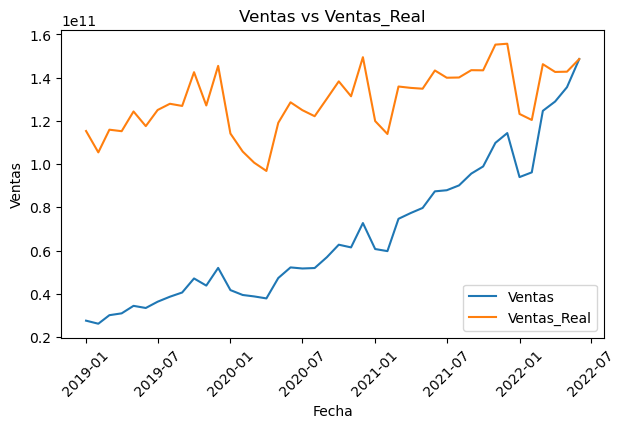

In [43]:
# Aplico la función para indexar valores respecto al último mes de la serie
indexar(ventas_ipc, 'Ventas')

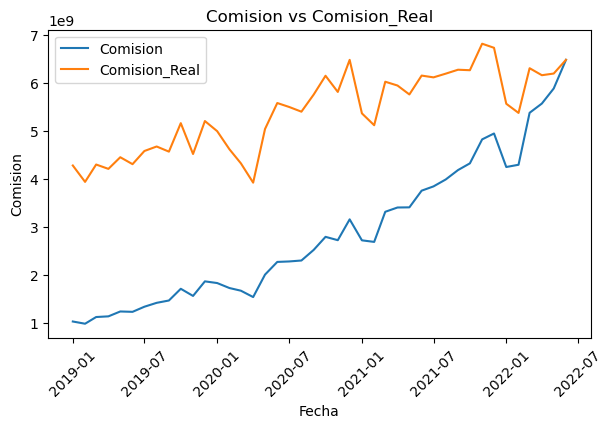

In [44]:
indexar(ventas_ipc, 'Comision')

Vemos gráficamente el efecto de la operación (por simplicidad se grafican mensualmente las series de tiempo agregando los valores por suma).

En las variantes llamadas "Reales", se observa una pendiente más moderada. El efecto de la inflación ha sido "descartado". De aquí en adelante, a la hora de hablar de los valores de estas variables, la interpretación correcta será "$ XX.XXX a precios de junio de 2022"

In [45]:
ventas_ipc.head(3)

,ID,Deposito,Ventas,Alicuota,Comision,Trat_Fisc,Trat_Fisc_Agg,Trat_Dif,CM,Subrubro,Omega,Modelo,FECHA,INDICE,Ventas_Real,Comision_Real
0,0,0,14622.16,0.028,409.42,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101,6.115592e+04,1712.363645
1,1,1,62477.00,0.040,2499.08,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101,2.613046e+05,10452.185376
2,1,2,3373941.00,0.040,134957.64,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101,1.411122e+07,564448.625587


In [46]:
# # Se descartan las variables que no se usan
ventas_ipc = limpiar_basic(ventas_ipc, cols_drop=['Ventas', 'Comision', 'INDICE'])

# Se renombran las variables
ventas_ipc.rename(columns = {'FECHA': 'Fecha', 'Ventas_Real': 'Ventas', 
                              'Comision_Real': 'Comision'}, inplace = True)

# Se reacomodan las columnas
ventas_ipc = ventas_ipc[['ID', 'Omega', 'Subrubro', 'Trat_Fisc_Agg', 
                          'Trat_Fisc', 'Trat_Dif', 'CM', 'Fecha', 'Deposito', 
                          'Ventas', 'Alicuota', 'Comision', 'Modelo']]

ventas_ipc = ventas_ipc.sort_values(['Fecha', 'Ventas']).reset_index(drop=True)

In [47]:
ventas_ipc

,ID,Omega,Subrubro,Trat_Fisc_Agg,Trat_Fisc,Trat_Dif,CM,Fecha,Deposito,Ventas,Alicuota,Comision,Modelo
0,2133,1,Venta Agrop.,NaN,Norm,No,0,2019-01-01,7,-1.116697e+07,2.00,-2.233394e+05,0
1,1172,1,Venta Agrop.,NaN,nan,No,0,2019-01-01,7,-5.494877e+06,2.40,-1.318771e+05,0
2,2589,1,Vehiculos,NaN,Norm,No,0,2019-01-01,47,-2.331939e+06,4.00,-9.327756e+04,0
3,1907,1,Venta Agrop.,NaN,Norm,No,0,2019-01-01,5,-1.131988e+06,2.00,-2.263974e+04,0
4,1478,1,Venta Agrop.,NaN,nan,No,0,2019-01-01,7,-4.177637e+05,2.40,-1.002633e+04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
378703,815,1,Supermercados,Norm,0,No,0,2022-06-01,8,1.567422e+09,0.05,7.837112e+07,0
378704,1098,1,Supermercados,NaN,Alic.Agrav,No,0,2022-06-01,130,1.732460e+09,5.00,8.662302e+07,0
378705,1091,1,Supermercados,NaN,Alic.Agrav,No,0,2022-06-01,130,2.240194e+09,5.00,1.120097e+08,0
378706,2862,1,Venta Agrop.,NaN,Alic.Agrav,No,0,2022-06-01,5,2.631098e+09,3.00,7.893293e+07,0


In [48]:
# Guardo todo lo hecho hasta acá, para no tener que correr todo
ventas_ipc.to_csv('../data/interim/tp2_ventas_ipc.csv', index=False)

---
# Análisis de variables numéricas (sin considerar series temporales)

### Estadística descriptiva

In [50]:
if 'ventas_ipc' not in locals():
    # Para que las funciones se actualicen si tener que refrescar el kernel
    %load_ext autoreload
    %autoreload 2

    import pandas as pd
    import json
    from os.path import exists
    import missingno as msno
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from statsmodels.graphics.tsaplots import plot_acf
    from scipy.stats import linregress as LR
    from scipy.stats import skew, kurtosis, skewtest, kurtosistest

    # Funciones propias
    from utils_limpieza import * 
    
    ventas_ipc = pd.read_csv('../data/interim/tp2_ventas_ipc.csv')

In [51]:
ventas_ipc.head()

,ID,Omega,Subrubro,Trat_Fisc_Agg,Trat_Fisc,Trat_Dif,CM,Fecha,Deposito,Ventas,Alicuota,Comision,Modelo
0,2133,1,Venta Agrop.,NaN,Norm,No,0,2019-01-01,7,-1.116697e+07,2.0,-223339.447058,0
1,1172,1,Venta Agrop.,NaN,nan,No,0,2019-01-01,7,-5.494877e+06,2.4,-131877.053284,0
2,2589,1,Vehiculos,NaN,Norm,No,0,2019-01-01,47,-2.331939e+06,4.0,-93277.561136,0
3,1907,1,Venta Agrop.,NaN,Norm,No,0,2019-01-01,5,-1.131988e+06,2.0,-22639.737670,0
4,1478,1,Venta Agrop.,NaN,nan,No,0,2019-01-01,7,-4.177637e+05,2.4,-10026.332056,0


In [53]:
# Discrimanción por tipo de variables
#temp_cols = ['Año', 'Mes', 'Fecha', 'IPC'] #elimino IPC
#ven_temp = ventas_ipc[temp_cols] 

cat_cols = ['ID', 'Omega', 'Subrubro', 'Trat_Fisc_Agg', 'Trat_Fisc', 'Trat_Dif',
'CM', 'Deposito', 'Modelo']
ven_cat = ventas_ipc[cat_cols]

num_cols = ['Ventas', 'Alicuota', 'Comision']
ven_num = ventas_ipc[num_cols]

- Vemos que en la variable `Alicuota` la dispersión de los datos está en el orden de la media, tomando valores desde 0% hasta 18%. Esto se ve reflejado en un z-Score que va desde -1 a 6 (igual al tp1).
- Esta tendencia a tener la cola derecha más larga también se nota en las otras dos variables. Sin embargo, en estos dos últimos casos la dispersión de datos es enorme: la desviación estándar es igual y un orden mayor que la media y el extremo superior del z-Score está en 83 y 108 para `Ventas` y `Comision`, respectivamente. (mejoró respecto al tp1 gracias a la normalización por IPC)

In [54]:
ven_num.describe().T

,count,mean,std,min,25%,50%,75%,max
Ventas,378708.0,1.435188e+07,7.355494e+07,-3.475437e+08,0.00,374052.822833,7.883521e+06,6.894934e+09
Alicuota,378708.0,3.203496e+00,2.784005e+00,0.000000e+00,0.05,4.000000,4.750000e+00,1.800000e+01
Comision,378708.0,5.978459e+05,3.193485e+06,-1.216403e+07,0.00,15270.549590,3.283335e+05,3.447467e+08


In [55]:
print('z-Score de los extremos de la variables numéricas:') 
for col in num_cols:
    zScore_min = (ven_num[col].min() - ven_num[col].mean()) / ven_num[col].std()
    zScore_max = (ven_num[col].max() - ven_num[col].mean()) / ven_num[col].std()

    print(f'\t{col}:')
    print(f'\t\t Mínimo: {zScore_min:.0f} \t Máximo: {zScore_max:.0f}')

z-Score de los extremos de la variables numéricas:
	Ventas:
		 Mínimo: -5 	 Máximo: 94
	Alicuota:
		 Mínimo: -1 	 Máximo: 5
	Comision:
		 Mínimo: -4 	 Máximo: 108


- Tanto `Ventas` como `Comision` tienen prácticamente un 42% de registros con valores nulos y un 0.32% de valores negativos, *i.e.* hay un 42-43% de registros con valores no positivos imputados. 
- Un valor nulo significa que o bien era realmente nulo o se encontraba entre -$100 y $1000 (en la variable original de ventas).
- `Alicuota` no posee registros negativos, pero sí tiene un 0.63% de registros nulos.

In [56]:
print('Proporción de valores negativos, nulos y positivos en las variables numéricas:') 
for col in num_cols:
    print(f'\t{col}')
    ans = len(ven_num[col])
    neg = len(ven_num[ven_num[col] < 0])
    nul = len(ven_num[ven_num[col] == 0])

    cant = [neg, nul, neg+nul, ans-neg-nul, ans]
    prop = [f'{100*neg/ans:.2f}%', f'{100*nul/ans:.2f}%', f'{100*(nul+neg)/ans:.2f}%', f'{100*(ans-nul-neg)/ans:.2f}%', '100.00%']
    desc = pd.DataFrame([cant, prop], columns=['Negativos', 'Nulos', 'No positivos', 'Positivos', 'Total'], index=['Cantidad', 'Proporcion'])
    display(desc)


Proporción de valores negativos, nulos y positivos en las variables numéricas:
	Ventas


,Negativos,Nulos,No positivos,Positivos,Total
Cantidad,1233,147061,148294,230414,378708
Proporcion,0.33%,38.83%,39.16%,60.84%,100.00%


	Alicuota


,Negativos,Nulos,No positivos,Positivos,Total
Cantidad,0,2343,2343,376365,378708
Proporcion,0.00%,0.62%,0.62%,99.38%,100.00%


	Comision


,Negativos,Nulos,No positivos,Positivos,Total
Cantidad,1207,149319,150526,228182,378708
Proporcion,0.32%,39.43%,39.75%,60.25%,100.00%


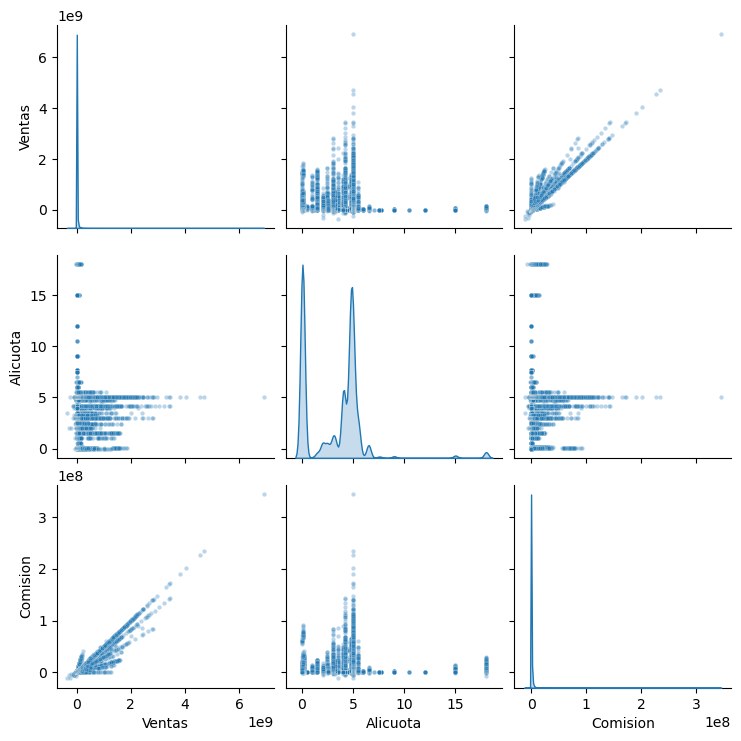

In [57]:
sns.pairplot(data=ven_num, diag_kind='kde', plot_kws = {'alpha': 0.3, 's': 10})
plt.show()

<Axes: >

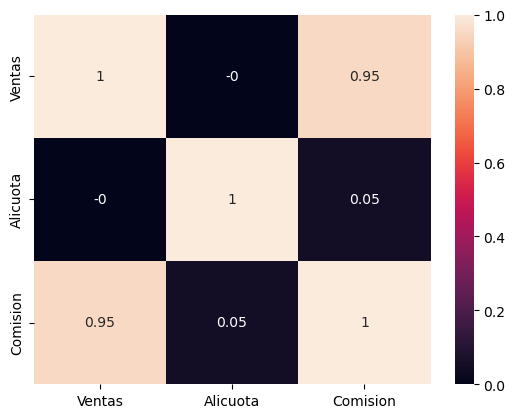

In [58]:
# Cálculo y Visualización de la matriz de correlación entre las variables
matrix = ven_num[['Ventas', 'Alicuota', 'Comision']].corr().round(2)
sns.heatmap(matrix, annot=True)

### Discriminando por tipo de venta
Dado el enorme peso de los valores nulos sobre el total de registros y la presencia de valores negativos, tanto en `Ventas` como en `Comision`, se decide dividir este DataFrame en tres:
1. Filtrado por `Ventas` nulas (`ven_num_null`)
2. Filtrado por `Ventas` negativas (`ven_num_neg`)
2. Filtrado por `Ventas` positivas (`ven_num_pos`)

#### DataFrame con todas las ventas nulas

Al hacer esto, vemos que todos los valores de `Comision` en `ven_num_null` también son nulos, independientemente del valor de `Alicuota`, la cual sigue ocupando el rango de 0% a 18%.

In [59]:
ven_num_null = ven_num[ven_num['Ventas'] == 0].copy()
ven_num_null.describe().T

,count,mean,std,min,25%,50%,75%,max
Ventas,147061.0,0.000000,0.000000,0.0,0.000,0.0,0.00,0.0
Alicuota,147061.0,3.494646,2.746518,0.0,0.055,4.6,4.75,18.0
Comision,147061.0,0.000000,0.000000,0.0,0.000,0.0,0.00,0.0


In [60]:
print('z-Score de los extremos de la variables numéricas:') 
for col in ['Alicuota']:
    zScore_min = (ven_num_null[col].min() - ven_num_null[col].mean()) / ven_num_null[col].std()
    zScore_max = (ven_num_null[col].max() - ven_num_null[col].mean()) / ven_num_null[col].std()

    print(f'\t{col}:')
    print(f'\t\t Mínimo: {zScore_min:.0f} \t Máximo: {zScore_max:.0f}')

z-Score de los extremos de la variables numéricas:
	Alicuota:
		 Mínimo: -1 	 Máximo: 5


#### DataFrame con todas las ventas negativas

- Hay 7 órdenes de magnitud de diferencia entre los valores mínimo y máximo de ventas y comisión.
- Los datos son asimétricos hacia la izquierda, igual son menos asimétricos que el conjunto global
- Hay casos donde la comisión es nula a pesar de que la venta no fue nula. ¿Esto podría estar asociado a las alícuotas nulas o a ciertos tratamientos fiscales o tema subrubro?

In [61]:
ven_num_neg = ven_num[ven_num['Ventas'] < 0].copy()
ven_num_neg.describe().T

,count,mean,std,min,25%,50%,75%,max
Ventas,1233.0,-5.017765e+06,2.036540e+07,-3.475437e+08,-2.001097e+06,-178021.212455,-15325.640441,-0.716723
Alicuota,1233.0,4.484690e+00,2.368225e+00,0.000000e+00,4.000000e+00,5.000000,5.000000,18.000000
Comision,1233.0,-2.087849e+05,7.849380e+05,-1.216403e+07,-8.551876e+04,-7400.433227,-662.316682,0.000000


In [62]:
print('z-Score de los extremos de la variables numéricas:') 
for col in num_cols:
    zScore_min = (ven_num_neg[col].min() - ven_num_neg[col].mean()) / ven_num_neg[col].std()
    zScore_max = (ven_num_neg[col].max() - ven_num_neg[col].mean()) / ven_num_neg[col].std()

    print(f'\t{col}:')
    print(f'\t\t Mínimo: {zScore_min:.0f} \t Máximo: {zScore_max:.0f}')

z-Score de los extremos de la variables numéricas:
	Ventas:
		 Mínimo: -17 	 Máximo: 0
	Alicuota:
		 Mínimo: -2 	 Máximo: 6
	Comision:
		 Mínimo: -15 	 Máximo: 0


* La mayoría de las ventas y comisiones están asociadas a alícuotas menores al 5% (con moda en 5%).
* Se proyecta una relación lineal entre `Ventas` y `Comision`: hay una correlación de +0.66. Chequear relación de proporcionaldiad con `Alicuota`

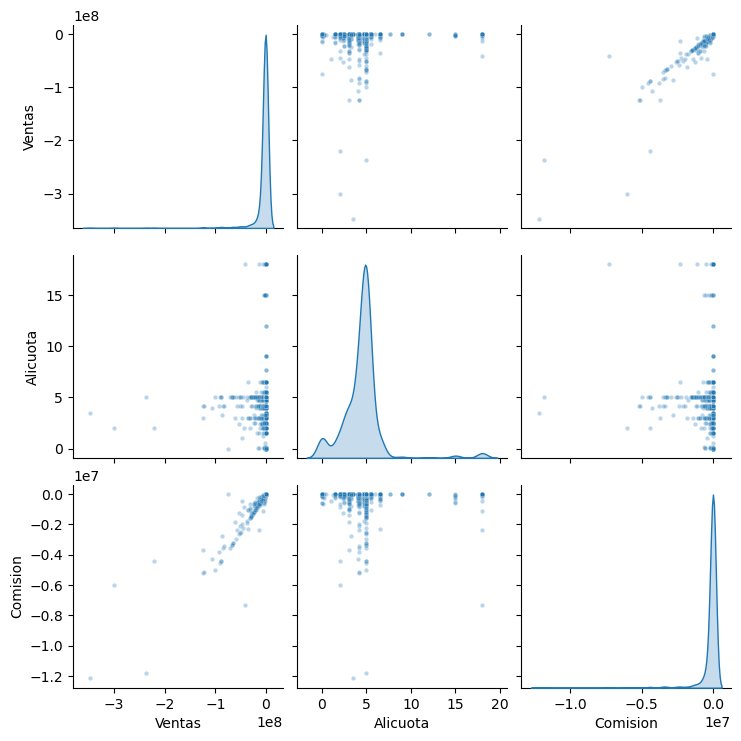

In [63]:
sns.pairplot(data=ven_num_neg, diag_kind='kde', plot_kws = {'alpha': 0.3, 's': 10})
plt.show()

<Axes: >

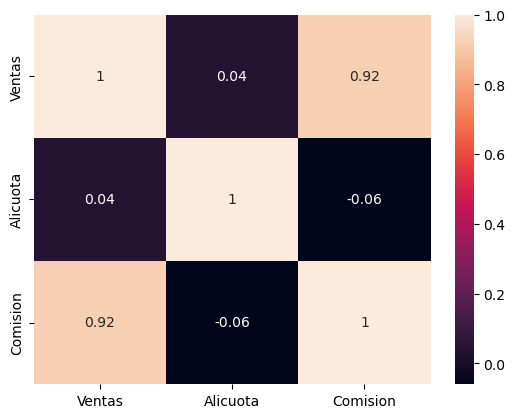

In [64]:
# Cálculo y Visualización de la matriz de correlación entre las variables
matrix = ven_num_neg[['Ventas', 'Alicuota', 'Comision']].corr().round(2)
sns.heatmap(matrix, annot=True)

#### DataFrame con todas las ventas positivas

- Hay 5 y 9 órdenes de magnitud de diferencia entre los valores mínimo y máximo de comisión y ventas, respectivamente.
- Los datos son asimétricos hacia la derecha, igual son menos asimétricos que el conjunto global.
- Hay casos donde la comisión es nula a pesar de que la venta no fue nula. ¿Esto podría estar asociado a las alícuotas nulas o a ciertos tratamientos fiscales o tema subrubro?

In [65]:
ven_num_pos = ven_num[ven_num['Ventas'] > 0].copy()
ven_num_pos.describe().T

,count,mean,std,min,25%,50%,75%,max
Ventas,230414.0,2.361557e+07,9.311775e+07,0.01,793537.203571,4.897819e+06,1.797292e+07,6.894934e+09
Alicuota,230414.0,3.010815e+00,2.791867e+00,0.00,0.047500,4.000000e+00,5.000000e+00,1.800000e+01
Comision,230414.0,9.837355e+05,4.046999e+06,0.00,32387.328981,2.022052e+05,7.519536e+05,3.447467e+08


In [66]:
print('z-Score de los extremos de la variables numéricas:') 
for col in num_cols:
    zScore_min = (ven_num_pos[col].min() - ven_num_pos[col].mean()) / ven_num_pos[col].std()
    zScore_max = (ven_num_pos[col].max() - ven_num_pos[col].mean()) / ven_num_pos[col].std()

    print(f'\t{col}:')
    print(f'\t\t Mínimo: {zScore_min:.0f} \t Máximo: {zScore_max:.0f}')

z-Score de los extremos de la variables numéricas:
	Ventas:
		 Mínimo: -0 	 Máximo: 74
	Alicuota:
		 Mínimo: -1 	 Máximo: 5
	Comision:
		 Mínimo: -0 	 Máximo: 85


* La mayoría de las ventas y comisiones están asociadas a alícuotas menores al 5%.
* Hay una distribución bimodal en torno al 0.0475% y el 5%
* Se proyectan diferentes rectas entre `Ventas` y `Comision`: ¿existe una relación de proporcionaldiad con `Alicuota`?
* Se proyecta una relación lineal entre `Ventas` y `Comision`: hay una correlación de +0.87. Chequear relación de proporcionaldiad con `Alicuota`

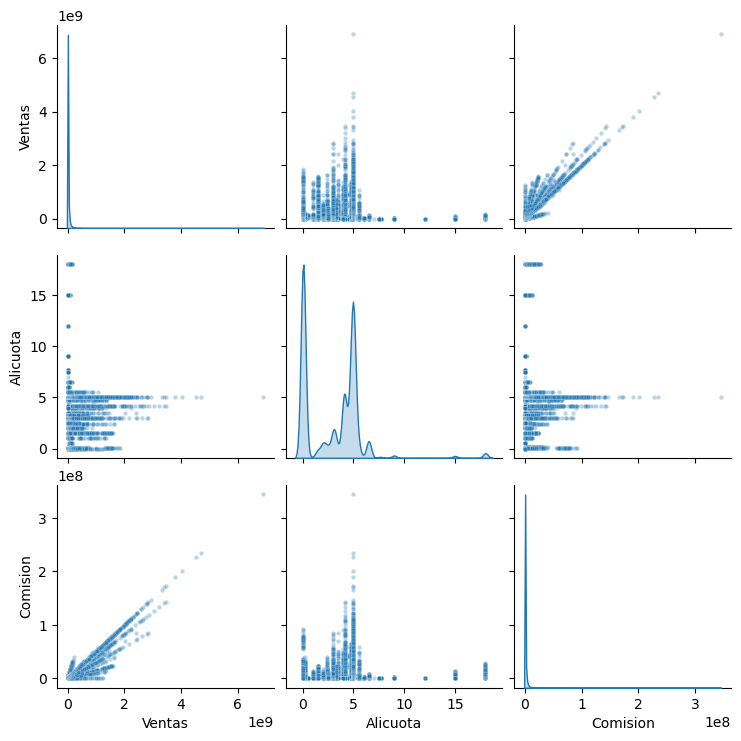

In [67]:
sns.pairplot(data=ven_num_pos, diag_kind='kde', plot_kws = {'alpha': 0.3, 's': 10})
plt.show()

<Axes: >

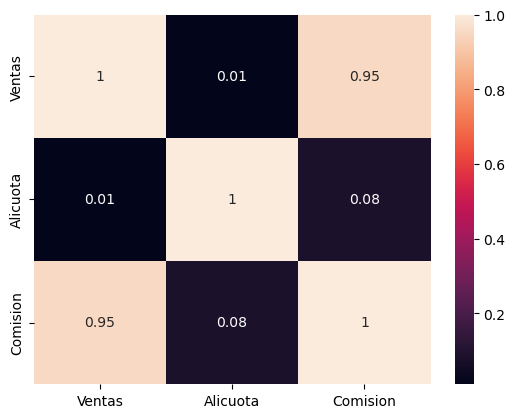

In [68]:
# Cálculo y Visualización de la matriz de correlación entre las variables
matrix = ven_num_pos[['Ventas', 'Alicuota', 'Comision']].corr().round(2)
sns.heatmap(matrix, annot=True)

### Más medidas de dispersión sobre ventas no nulas: asimetría y Kurtosis

Al analizar la asimetría (skewness) y la Kurtosis sobre estas variables decimos que:
* Las ventas positivas tienen un sesgo positivos y las negativas un sesgo negativo tanto para comisión como para ventas, como ya habíamos visto: las colas de las distribuciones se encuentran a derecha e izquierda, respectivamente.
* Las comisiones siempre tienen sesgo positivo: colas a derecha.
* Todas son leptocúrticas: están más apuntaladas y con colas más gruesas que la normal.
* Todos los p-valores son nulos en ambos test, lo cual indica que rechazamos la hipótesis nula: tanto en simetría como en Kurtosis las distribuciones son significativamente diferentes a una distribución normal.

In [69]:
print('Ventas negativas')
asim = skew(ven_num_neg)
asimtest = skewtest(ven_num_neg).pvalue
kurt = kurtosis(ven_num_neg)
kurttest = kurtosistest(ven_num_neg).pvalue

desc = pd.DataFrame({'Asimetría': asim, 'p-val Asim.': asimtest,
                     'Kurtosis (Fisher)': kurt, 'p-val Kurt.': kurttest},
                     index=['Ventas', 'Alicuota', 'Comision'])
desc

Ventas negativas


,Asimetría,p-val Asim.,Kurtosis (Fisher),p-val Kurt.
Ventas,-9.845730,0.000000e+00,127.533086,2.871108e-118
Alicuota,2.755404,1.940313e-115,15.245549,3.229661e-63
Comision,-8.452926,1.123207e-282,97.383275,2.644955e-112


In [70]:
print('Ventas positivas')
asim = skew(ven_num_pos)
asimtest = skewtest(ven_num_pos).pvalue
kurt = kurtosis(ven_num_pos)
kurttest = kurtosistest(ven_num_pos).pvalue

desc = pd.DataFrame({'Asimetría': asim, 'p-val Asim.': asimtest,
                     'Kurtosis (Fisher)': kurt, 'p-val Kurt.': kurttest},
                     index=['Ventas', 'Alicuota', 'Comision'])
desc

Ventas positivas


,Asimetría,p-val Asim.,Kurtosis (Fisher),p-val Kurt.
Ventas,16.564224,0.0,469.714264,0.0
Alicuota,1.444401,0.0,6.241373,0.0
Comision,19.664820,0.0,689.741211,0.0


### Relación entre variables numéricas con etiquetas categóricas

In [71]:
ventas_null = ventas_ipc[ventas_ipc['Ventas'] == 0].copy()
ventas_neg = ventas_ipc[ventas_ipc['Ventas'] < 0].copy()
ventas_pos = ventas_ipc[ventas_ipc['Ventas'] > 0].copy()

#### Ventas nulas

- Omega: prácticamente todos 1. Hay una nadita de 0.
- Subrubro: nada particular.
- Trat_Fisc_Agg: casi todos normales, algunos exentos y ni se ven los otros.
- Trat_Fisc: la enorme mayoría son 0. Después destacan apenitas los normales.
- Trat_Dif: la enorme mayoría no tiene. espués destacan apenitas los artículos 16 y 21.
- CM: prácticamente todos 0. Hay una nadita de 1. Se repite lo que vimos en el tp1: todos los CM1 están acá. Identificar a este vendedor y eliminar.
- Modelo: la gran mayoría no lo son, aunque sí hay varios modelo (en torno al cero).

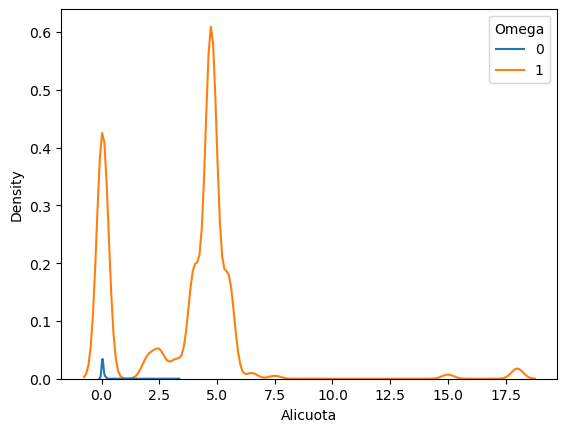

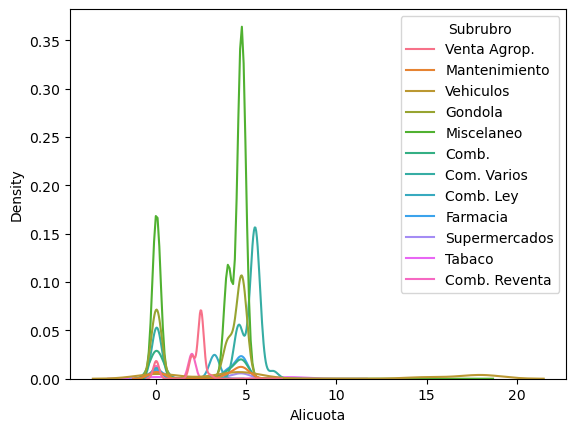

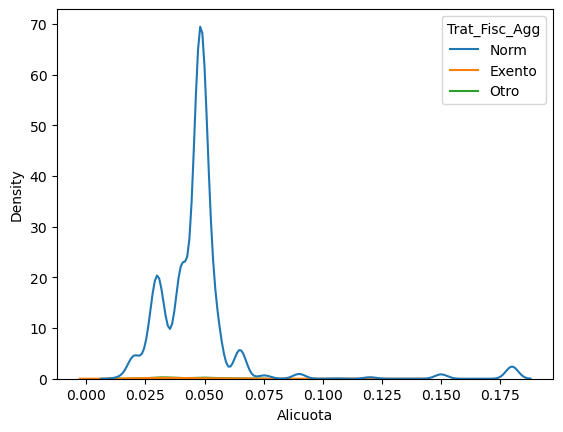

/tmp/ipykernel_124938/2644361636.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=ventas_null[['Alicuota', col]], x='Alicuota', hue=col)


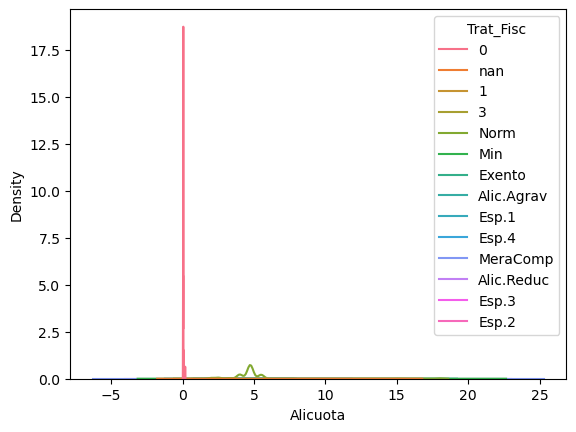

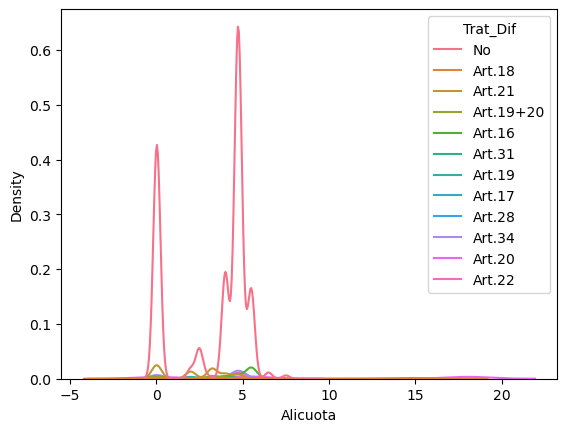

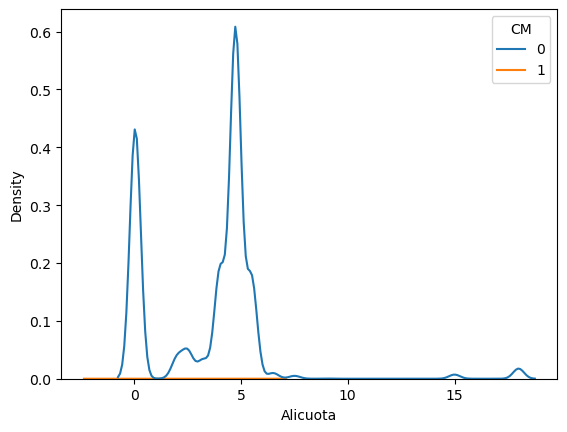

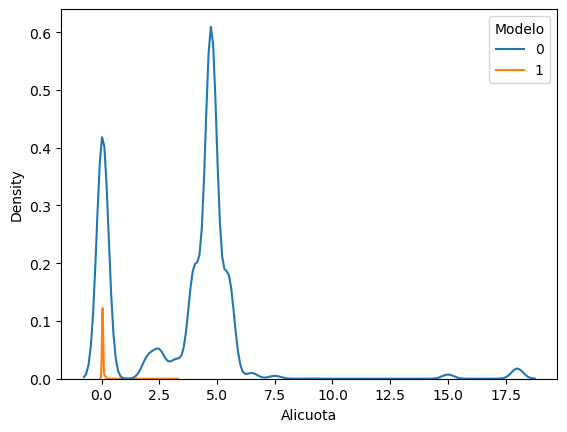

In [72]:
# Estas gráficas tardan bastante en generarse, descomentar para obtenerlas

for col in ['Omega', 'Subrubro', 'Trat_Fisc_Agg', 'Trat_Fisc', 'Trat_Dif', 'CM', 'Modelo']:
    sns.kdeplot(data=ventas_null[['Alicuota', col]], x='Alicuota', hue=col)
    plt.show()

#### Ventas negativas

- Omega: todos son 1.
- Subrubro: destacan misceláneo, supermercados y combustible reventa.
- Trat_Fisc_Agg: la enorme mayoría son normal, una nada de exentos. No hay otros.
- Trat_Fisc: nada particular.
- Trat_Dif: mayoritariamente no.
- CM: todos son 0.
- Modelo: todos son 0 (no hay ningún modelo con ventas negativas).

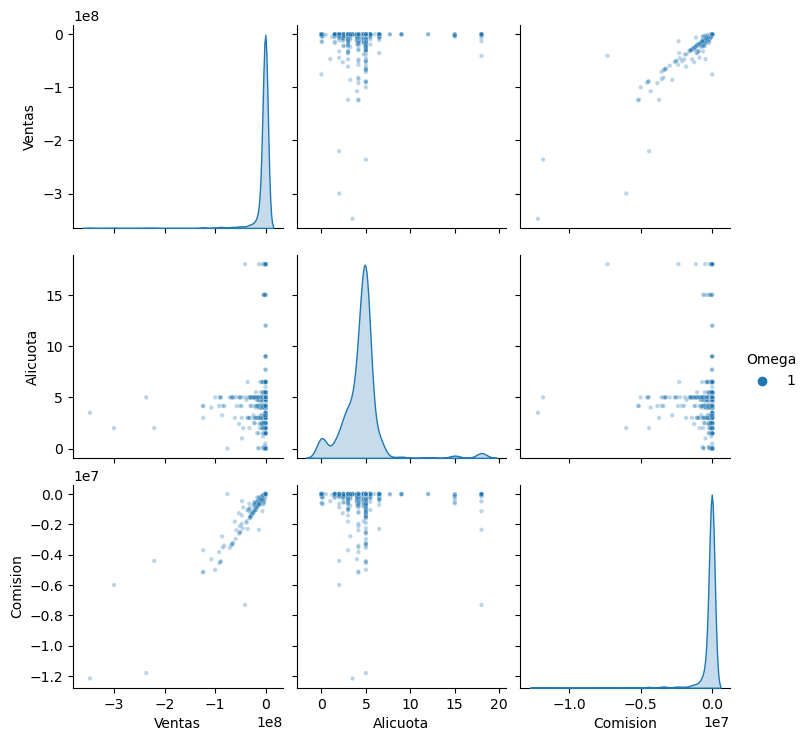

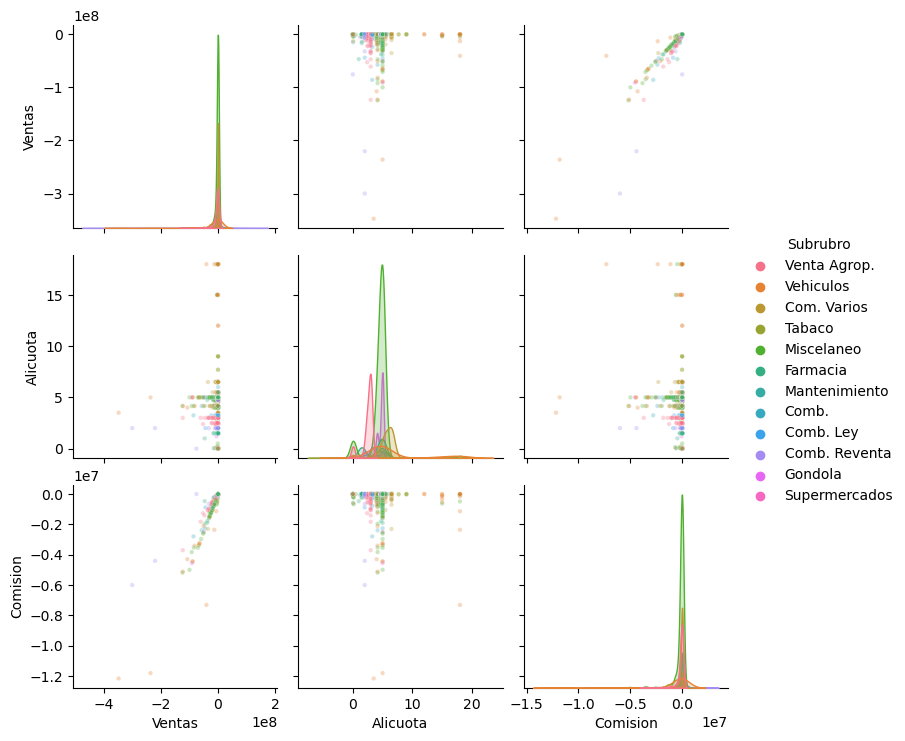

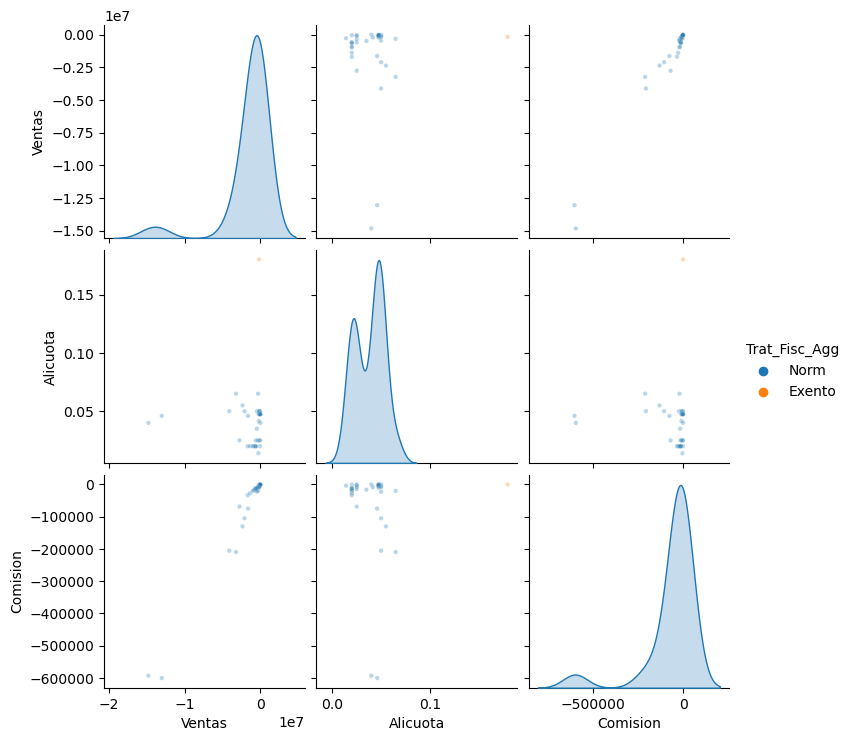

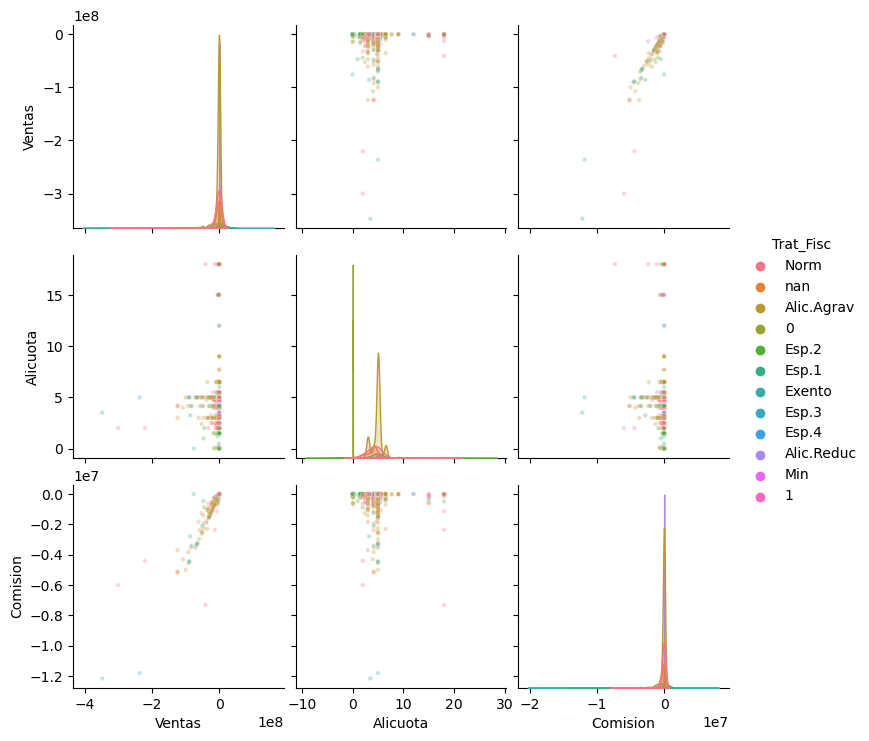

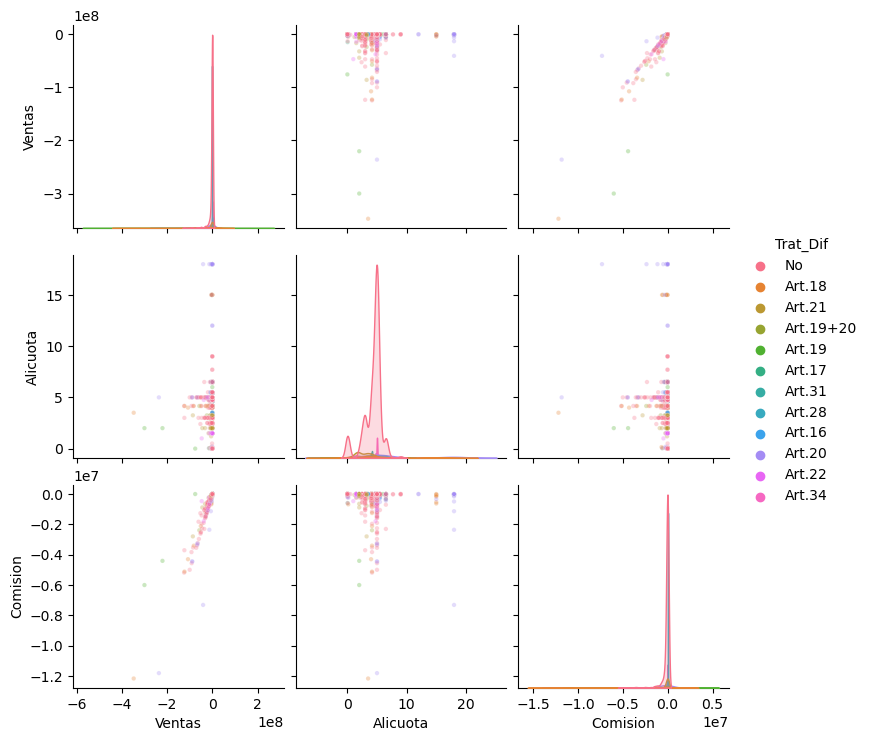

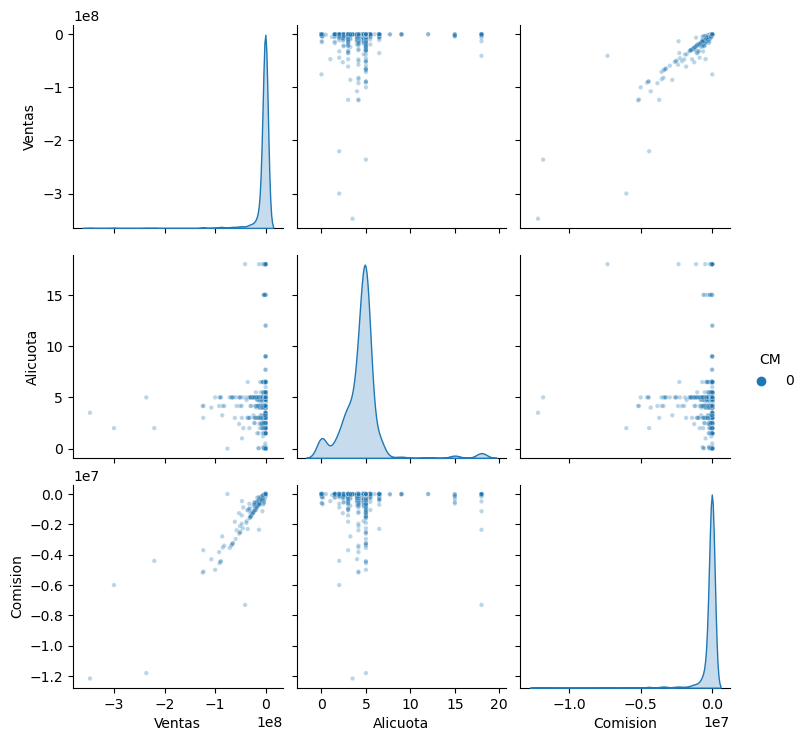

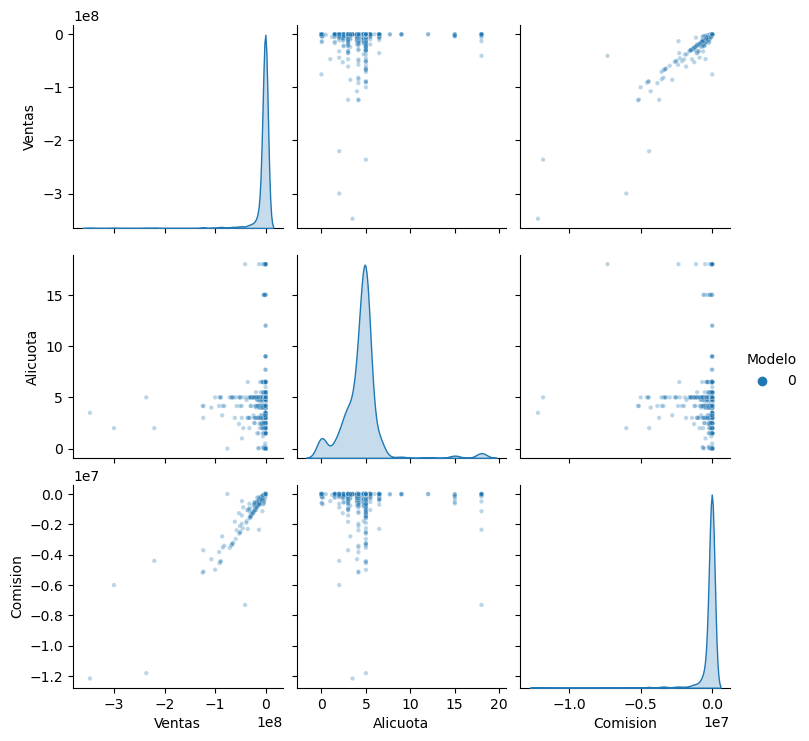

In [73]:
# Estas gráficas tardan bastante en generarse, descomentar para obtenerlas

for col in ['Omega', 'Subrubro', 'Trat_Fisc_Agg', 'Trat_Fisc', 'Trat_Dif', 'CM', 'Modelo']:
    sns.pairplot(data=ventas_neg[num_cols+[col]], diag_kind='kde', hue=col, plot_kws = {'alpha': 0.3, 's': 10})
    plt.show()

#### Ventas positivas

- Omega: la enorme mayoría son 1. Hay poquititos 1.
- Subrubro: ver cómo se asocian a las diferentes proyecciones.
- Trat_Fisc_Agg: casi todo normal. Algunos otros. También hay exento y mínimo.
- Trat_Fisc: sumar esto al análisis de subrurbo (distinguir primero por subrubro y dentro de cada uno diferenciar entre Trat Fisc).
- Trat_Dif: como el item anterior.
- CM: todos son 0.
- Modelo: hay tanto 0 como 1. Hay una mayor proporción de 1 que antes

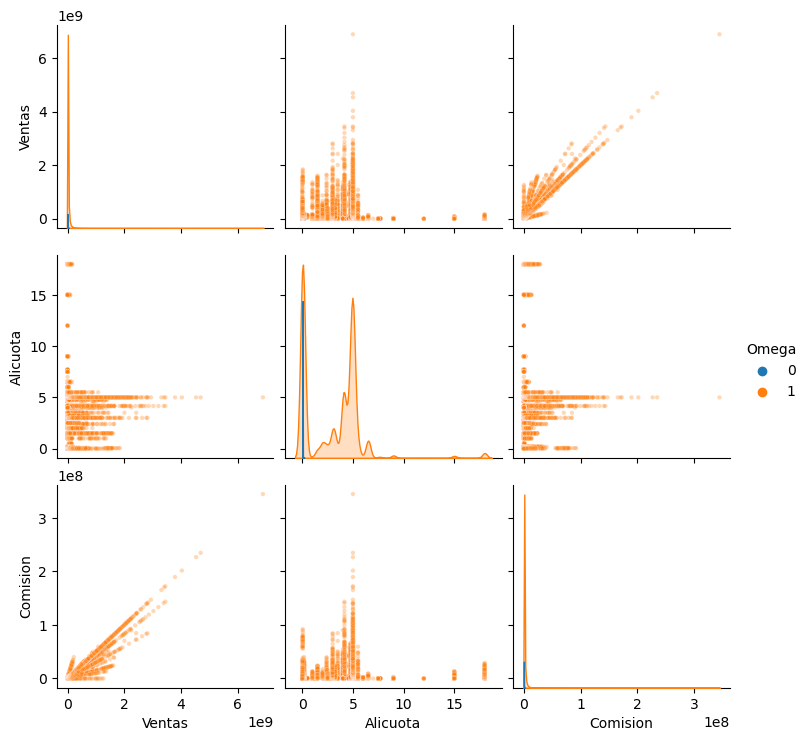

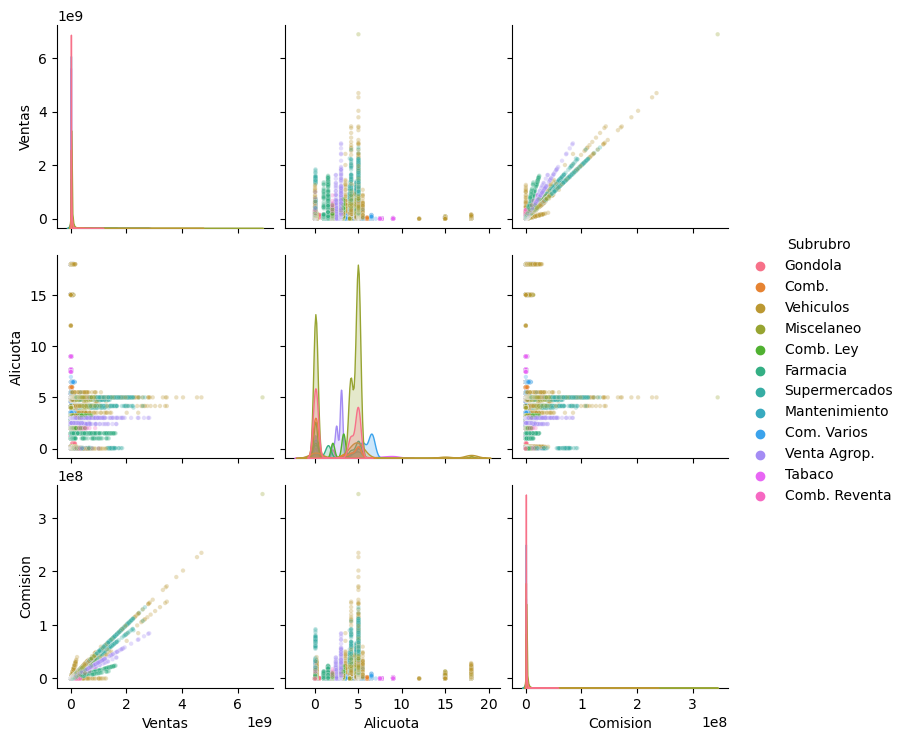

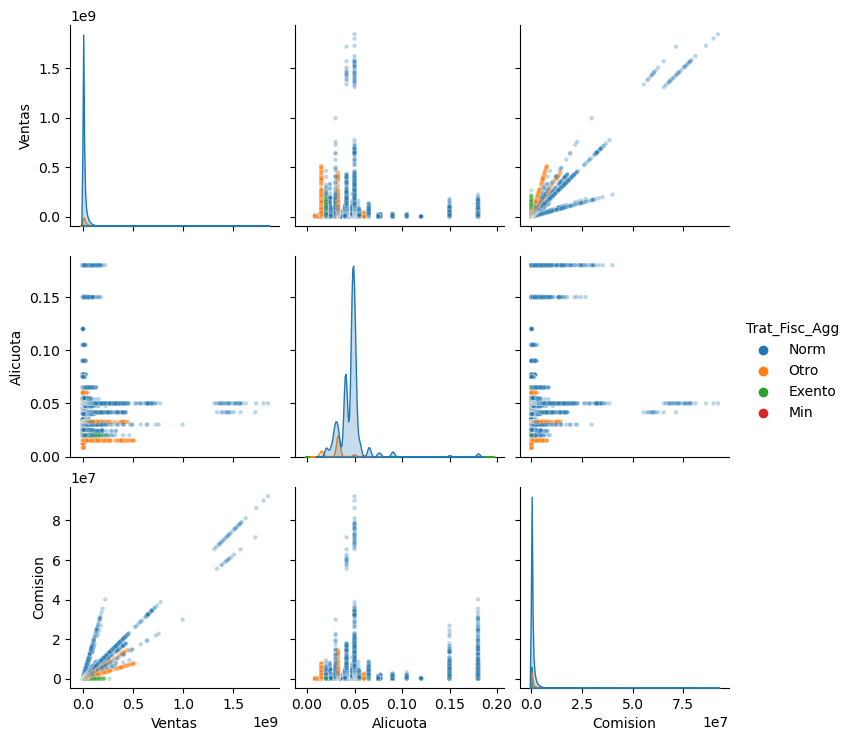

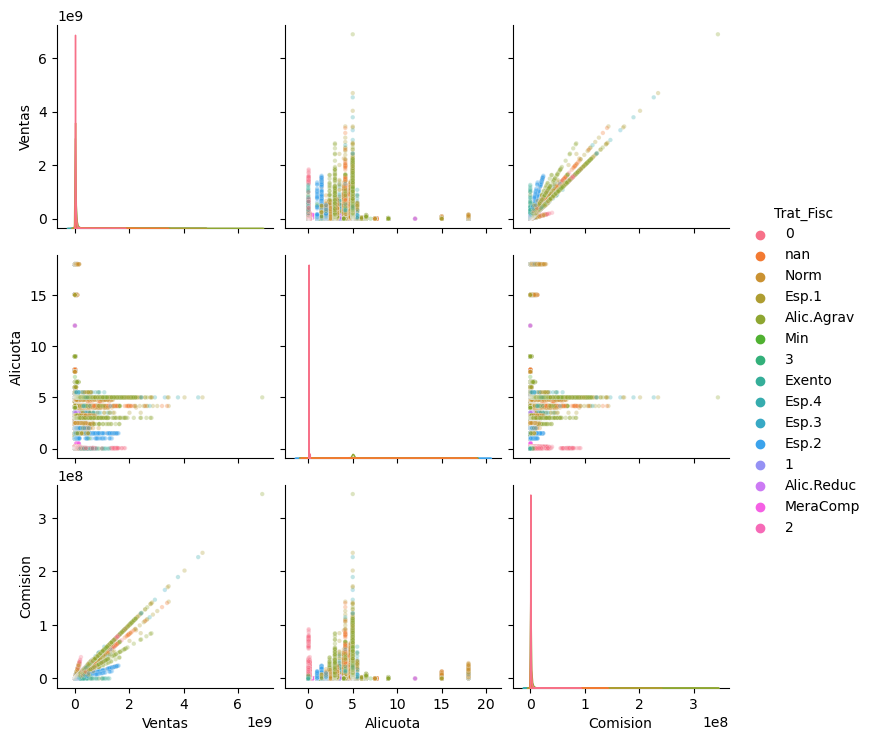

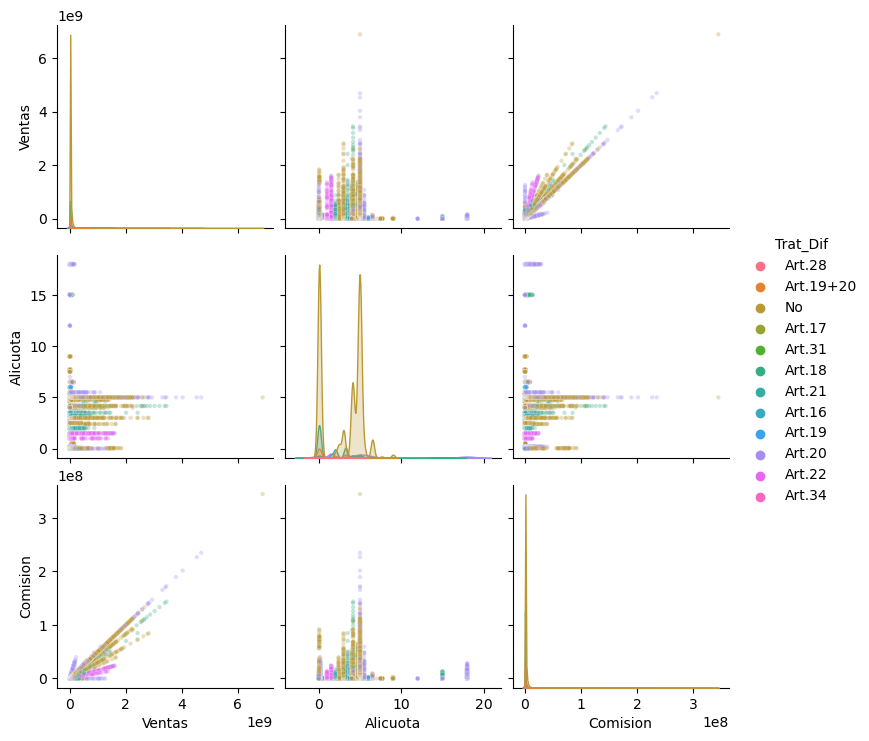

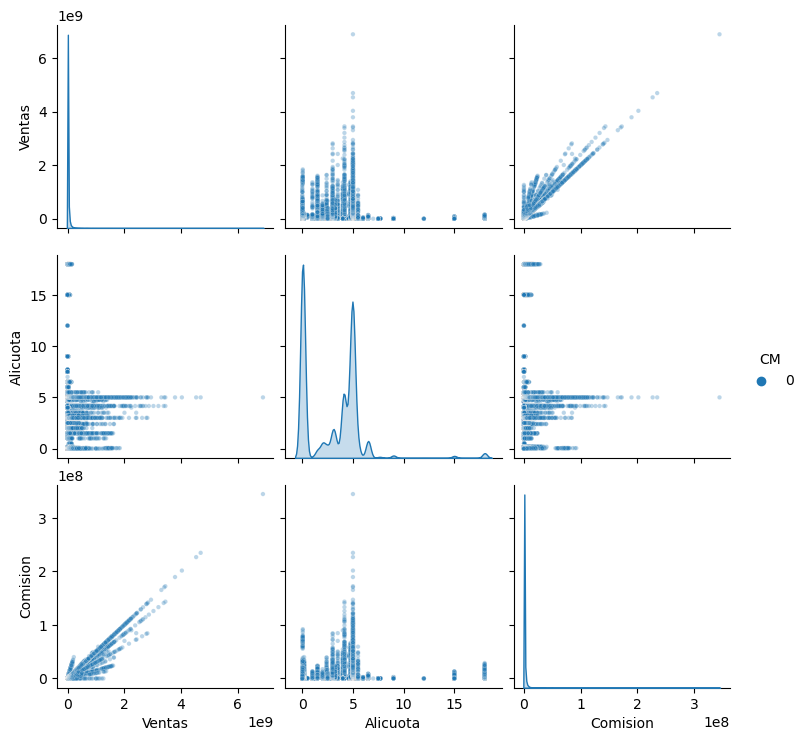

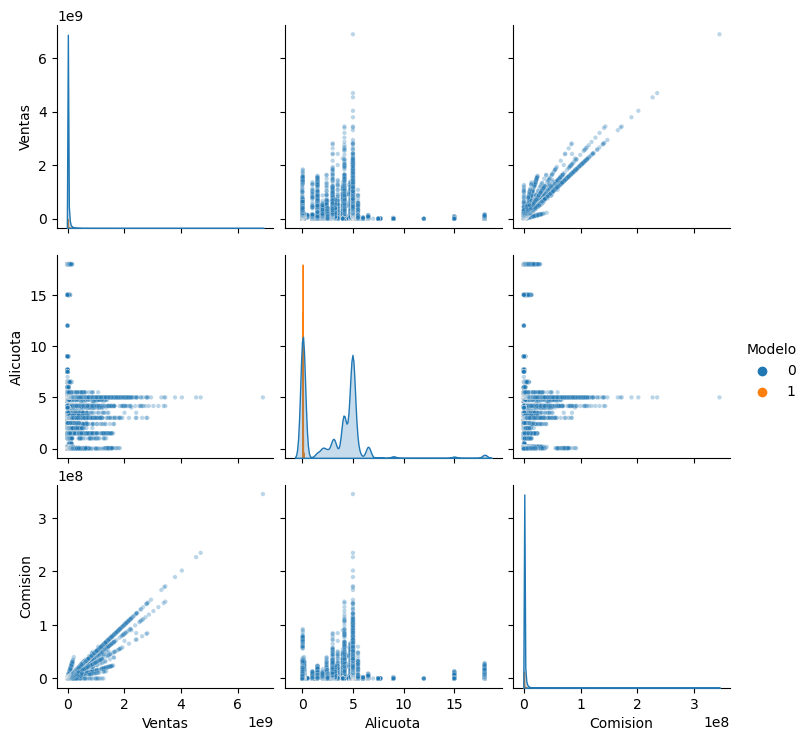

In [74]:
# Estas gráficas tardan bastante en generarse, descomentar para obtenerlas

for col in ['Omega', 'Subrubro', 'Trat_Fisc_Agg', 'Trat_Fisc', 'Trat_Dif', 'CM', 'Modelo']:
    sns.pairplot(data=ventas_pos[num_cols+[col]], diag_kind='kde', hue=col, plot_kws = {'alpha': 0.3, 's': 10})
    plt.show()

#### Nota sobre modelos
- No hay ningún modelo con ventas nulas: la mayoría de sus registros son ventas positivas, aunque hay algunos con ventas negativas.
- Todos los modeos tienen comisiones bajas (muy ceranas al 0%).

### Análisis de la relación de proporcionalidad entre variables numéricas

Queremos estudiar un poco más la relación lineal antes vista entre estas 3 variables. Proponemos que la función que las relaciona es
    $$\text{Comision} = \text{Alicuota} \times \text{Ventas}$$

Acá voy a volver a distinguir entre nulas, positivas y negativas e ir discriminando por modelo

#### Ventas nulas

In [75]:
# Relación lineal: comision = alicuota x venta
calcCom = ventas_null['Alicuota'] * ventas_null['Ventas']

L = len(calcCom)
S = sum(abs(ventas_null['Comision'] - calcCom) == 0)
print(f'{S} de {L} registros cumplen la relación >> {100*(S)/L:.2f}%')
print(f'{L-S} registros no la cumplen la relación >> {100*(L-S)/L:.2f}%')

147061 de 147061 registros cumplen la relación >> 100.00%
0 registros no la cumplen la relación >> 0.00%


#### Ventas negativas

In [76]:
# Relación lineal: comision = alicuota x venta
calcCom = ventas_neg['Alicuota'] * ventas_neg['Ventas']

diff = ventas_neg['Comision'] - calcCom
D = len(diff)
L = len(calcCom)
S = sum(abs(diff) == 0)

print(f'{S} de {L} registros cumplen la relación >> {100*(S)/L:.2f}%')
print(f'{L-S} registros no la cumplen la relación >> {100*(L-S)/L:.2f}%')

sobre = len(diff[diff<0])
print(f'\t{sobre} registros sobreestiman la relación >>> {100*sobre/D:.2f}%')
sub = len(diff[diff>0])
print(f'\t{sub} registros subestiman la relación >>> {100*sub/D:.2f}%')

30 de 1233 registros cumplen la relación >> 2.43%
1203 registros no la cumplen la relación >> 97.57%
	17 registros sobreestiman la relación >>> 1.38%
	1186 registros subestiman la relación >>> 96.19%


In [77]:
com_real_sobre = ventas_neg['Comision'][diff<0]
com_real_exac = ventas_neg['Comision'][diff==0]
com_real_sub = ventas_neg['Comision'][diff>0]

com_calc_sobre = calcCom[diff<0]
com_calc_exac = calcCom[diff==0]
com_calc_sub = calcCom[diff>0]

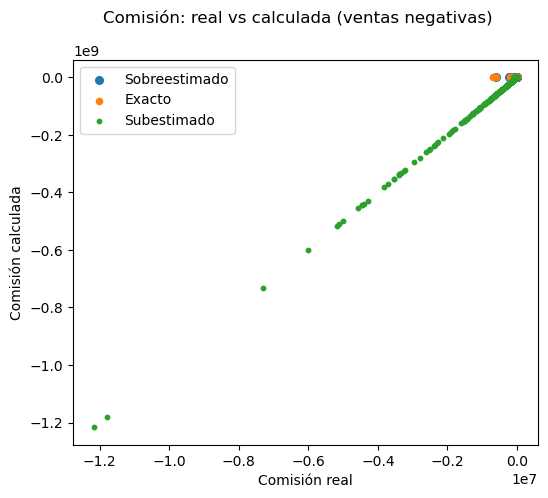

In [78]:
fig, axs = plt.subplots(figsize=(6, 5))

fig.suptitle('Comisión: real vs calculada (ventas negativas)')

axs.scatter(com_real_sobre, com_calc_sobre, label='Sobreestimado', s=30)
axs.scatter(com_real_exac, com_calc_exac, label='Exacto', s=20)
axs.scatter(com_real_sub, com_calc_sub, label='Subestimado', s=10)

axs.legend()

axs.set_xlabel('Comisión real')
axs.set_ylabel('Comisión calculada')

plt.show()

In [79]:
rg_real = pd.concat([com_real_sub[com_calc_sub<0], com_real_sobre[com_calc_sobre>10*com_real_sobre]])
rg_calc = pd.concat([com_calc_sub[com_calc_sub<0], com_calc_sobre[com_calc_sobre>10*com_real_sobre]])

rp_real = pd.concat([com_real_sub[com_calc_sub>0], com_real_sobre[com_calc_sobre<10*com_real_sobre], com_real_exac])
rp_calc = pd.concat([com_calc_sub[com_calc_sub>0], com_calc_sobre[com_calc_sobre<10*com_real_sobre], com_calc_exac])

In [80]:
print(f'De los {len(rp_real+rg_real)} registros:')
print(f'\t{len(rg_real)} están en la recta con pendiente grande >>> {100*len(rg_real)/len(rp_real+rg_real):.2f}%')
print(f'\t{len(rp_real)} están en la recta con pendiente pequeña >>> {100*len(rp_real)/len(rp_real+rg_real):.2f}%')

De los 1233 registros:
	1203 están en la recta con pendiente grande >>> 97.57%
	30 están en la recta con pendiente pequeña >>> 2.43%


In [81]:
LG = LR(rg_real, rg_calc)
LP = LR(rp_real, rp_calc)

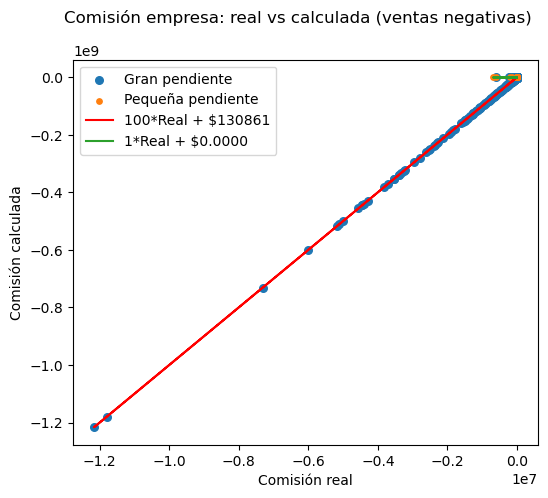

In [82]:
fig, axs = plt.subplots(figsize=(6, 5))

axs.scatter(rg_real, rg_calc, label='Gran pendiente', s=30)
axs.scatter(rp_real, rp_calc, label='Pequeña pendiente', s=15)
axs.plot(rg_real, rg_real*LG.slope + LG.intercept, label=f'{LG.slope:.0f}*Real + ${LG.intercept:.0f}', color='red')
axs.plot(rp_real, rp_real*LP.slope + LP.intercept, label=f'{LP.slope:.0f}*Real + ${LP.intercept:.4f}', color='tab:green')

axs.legend(loc='upper left')

axs.set_xlabel('Comisión real')
axs.set_ylabel('Comisión calculada')

fig.suptitle('Comisión empresa: real vs calculada (ventas negativas)')
plt.show()

In [83]:
# Discrimino por modelo
mask0 = ventas_neg['Modelo']==0
mask1 = ventas_neg['Modelo']==1

In [84]:
com_real_Mod = ventas_neg['Comision'][mask1]
com_real_noMod = ventas_neg['Comision'][mask0]

com_calc_Mod = calcCom[mask1]
com_calc_noMod = calcCom[mask0]

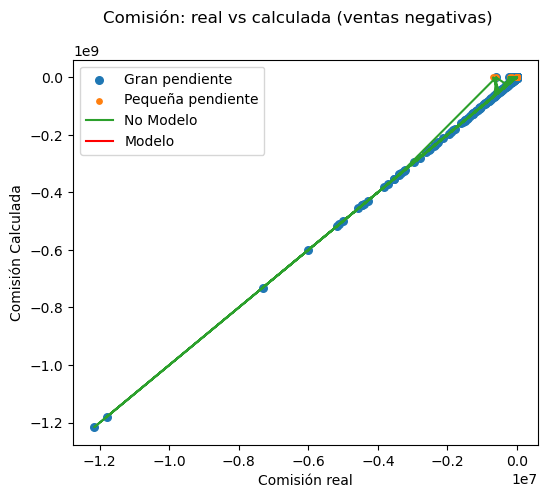

In [85]:
fig, axs = plt.subplots(figsize=(6, 5))

axs.scatter(rg_real, rg_calc, label='Gran pendiente', s=30)
axs.scatter(rp_real, rp_calc, label='Pequeña pendiente', s=15)
axs.plot(com_real_noMod, com_calc_noMod, label='No Modelo', color='tab:green')
axs.plot(com_real_Mod, com_calc_Mod, label='Modelo', color='red')

axs.legend(loc='upper left')

axs.set_xlabel('Comisión real')
axs.set_ylabel('Comisión Calculada')

fig.suptitle('Comisión: real vs calculada (ventas negativas)')
plt.show()

#### Ventas positivas

In [86]:
# Relación lineal: comision = alicuota x venta
calcCom = ventas_pos['Alicuota'] * ventas_pos['Ventas']

diff = ventas_pos['Comision'] - calcCom
D = len(diff)
L = len(calcCom)
S = sum(abs(diff) == 0)

print(f'{S} de {L} registros cumplen la relación >> {100*(S)/L:.2f}%')
print(f'{L-S} registros no la cumplen la relación >> {100*(L-S)/L:.2f}%')

sobre = len(diff[diff<0])
print(f'\t{sobre} registros sobreestiman la relación >>> {100*sobre/D:.2f}%')
sub = len(diff[diff>0])
print(f'\t{sub} registros subestiman la relación >>> {100*sub/D:.2f}%')

6782 de 230414 registros cumplen la relación >> 2.94%
223632 registros no la cumplen la relación >> 97.06%
	187875 registros sobreestiman la relación >>> 81.54%
	35757 registros subestiman la relación >>> 15.52%


In [87]:
com_real_sobre = ventas_pos['Comision'][diff<0]
com_real_exac = ventas_pos['Comision'][diff==0]
com_real_sub = ventas_pos['Comision'][diff>0]

com_calc_sobre = calcCom[diff<0]
com_calc_exac = calcCom[diff==0]
com_calc_sub = calcCom[diff>0]

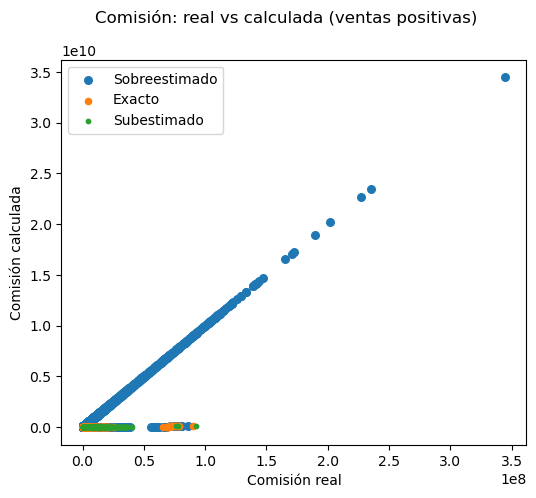

In [88]:
fig, axs = plt.subplots(figsize=(6, 5))

fig.suptitle('Comisión: real vs calculada (ventas positivas)')

axs.scatter(com_real_sobre, com_calc_sobre, label='Sobreestimado', s=30)
axs.scatter(com_real_exac, com_calc_exac, label='Exacto', s=20)
axs.scatter(com_real_sub, com_calc_sub, label='Subestimado', s=10)

axs.legend()

axs.set_xlabel('Comisión real')
axs.set_ylabel('Comisión calculada')

plt.show()

In [89]:
rg_real = pd.concat([com_real_sub[com_calc_sub<0], com_real_sobre[com_calc_sobre>10*com_real_sobre]])
rg_calc = pd.concat([com_calc_sub[com_calc_sub<0], com_calc_sobre[com_calc_sobre>10*com_real_sobre]])

rp_real = pd.concat([com_real_sub[com_calc_sub>0], com_real_sobre[com_calc_sobre<10*com_real_sobre], com_real_exac])
rp_calc = pd.concat([com_calc_sub[com_calc_sub>0], com_calc_sobre[com_calc_sobre<10*com_real_sobre], com_calc_exac])

In [90]:
print(f'De los {len(rp_real+rg_real)} registros:')
print(f'\t{len(rg_real)} están en la recta con pendiente grande >>> {100*len(rg_real)/len(rp_real+rg_real):.2f}%')
print(f'\t{len(rp_real)} están en la recta con pendiente pequeña >>> {100*len(rp_real)/len(rp_real+rg_real):.2f}%')

De los 230414 registros:
	147581 están en la recta con pendiente grande >>> 64.05%
	82833 están en la recta con pendiente pequeña >>> 35.95%


In [91]:
LG = LR(rg_real, rg_calc)
LP = LR(rp_real, rp_calc)

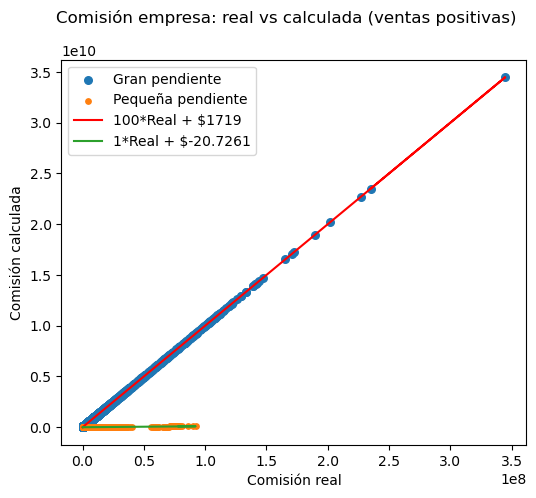

In [92]:
fig, axs = plt.subplots(figsize=(6, 5))

axs.scatter(rg_real, rg_calc, label='Gran pendiente', s=30)
axs.scatter(rp_real, rp_calc, label='Pequeña pendiente', s=15)
axs.plot(rg_real, rg_real*LG.slope + LG.intercept, label=f'{LG.slope:.0f}*Real + ${LG.intercept:.0f}', color='red')
axs.plot(rp_real, rp_real*LP.slope + LP.intercept, label=f'{LP.slope:.0f}*Real + ${LP.intercept:.4f}', color='tab:green')

axs.legend(loc='upper left')

axs.set_xlabel('Comisión real')
axs.set_ylabel('Comisión calculada')

fig.suptitle('Comisión empresa: real vs calculada (ventas positivas)')
plt.show()

In [93]:
# Discrimino por modelo
mask0 = ventas_pos['Modelo']==0
mask1 = ventas_pos['Modelo']==1

In [94]:
com_real_Mod = ventas_pos['Comision'][mask1]
com_real_noMod = ventas_pos['Comision'][mask0]

com_calc_Mod = calcCom[mask1]
com_calc_noMod = calcCom[mask0]

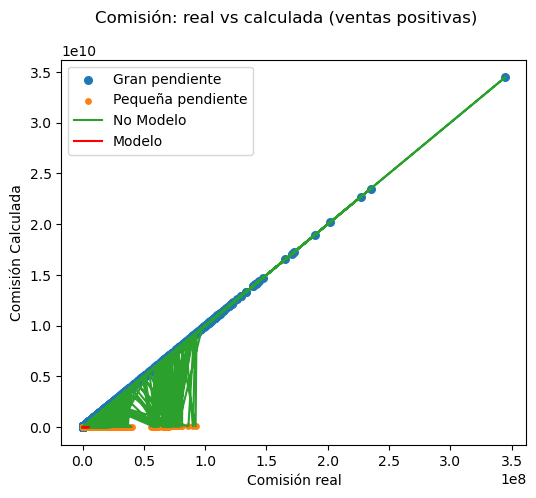

In [95]:
fig, axs = plt.subplots(figsize=(6, 5))

axs.scatter(rg_real, rg_calc, label='Gran pendiente', s=30)
axs.scatter(rp_real, rp_calc, label='Pequeña pendiente', s=15)
axs.plot(com_real_noMod, com_calc_noMod, label='No Modelo', color='tab:green')
axs.plot(com_real_Mod, com_calc_Mod, label='Modelo', color='red')

axs.legend(loc='upper left')

axs.set_xlabel('Comisión real')
axs.set_ylabel('Comisión Calculada')

fig.suptitle('Comisión: real vs calculada (ventas positivas)')
plt.show()

---
# Análisis de variables categóricas

In [96]:
ventas_categ = ventas_ipc.drop(['Ventas', 'Alicuota', 'Comision'], axis=1).copy()
ventas_categ.head(3)

,ID,Omega,Subrubro,Trat_Fisc_Agg,Trat_Fisc,Trat_Dif,CM,Fecha,Deposito,Modelo
0,2133,1,Venta Agrop.,NaN,Norm,No,0,2019-01-01,7,0
1,1172,1,Venta Agrop.,NaN,nan,No,0,2019-01-01,7,0
2,2589,1,Vehiculos,NaN,Norm,No,0,2019-01-01,47,0


### `ID` y `Modelo`

In [97]:
checkear_unicidad(ventas_categ, 'Modelo', 'ID')

Para cada ID solo existe un valor de Modelo.


Esto implica, que si hay un vendedor Modelo que vende en más de un rubro, tiene la etiqueta de Modelo en todos los rubros.

### `Omega` y `Modelo`

En primer lugar, verificar si a cada ID único se le asigna un único valor de Omega (no debería pasar lo contrario)

In [98]:
checkear_unicidad(ventas_categ, 'Omega', 'ID')

Para cada ID solo existe un valor de Omega.


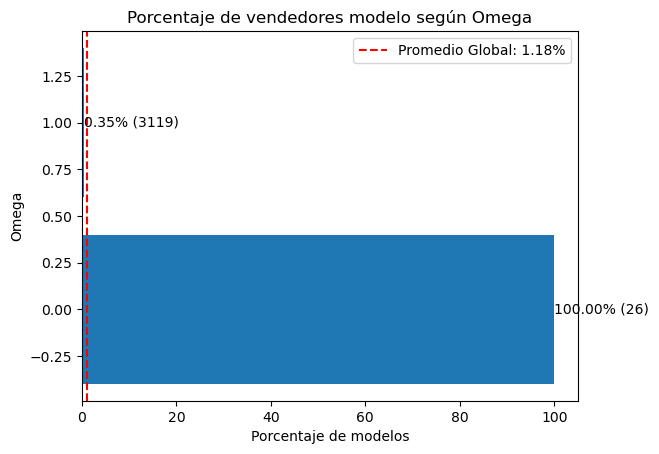

In [99]:
graficar_modelo(ventas_categ, 'Omega')

Dentro de los vendedores que son Omega (3119), solo el 0,35% es modelo.
Mientras que entre los no Omega (26), el 100% es modelo.

### `Subrubro` y `Modelo`

In [101]:
checkear_unicidad(ventas_categ, 'Subrubro', 'ID')

Para algunos ID se asignan diferentes valores de Subrubro:
ID
1992    10
1219    10
1479    10
1420     9
1530     9
        ..
1383     2
1384     2
1386     2
1390     2
3142     2
Name: Subrubro, Length: 1484, dtype: int64


En secciones previas se probó que si un ID era Modelo en un rubro, también lo era en todos.

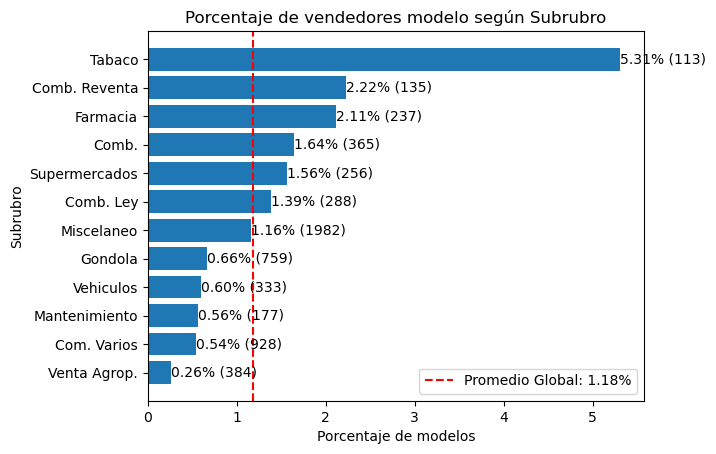

In [102]:
graficar_modelo(ventas_categ, 'Subrubro')

### `Trat_Fisc_Agg` y `Modelo`

De qué depende el tratamiento fiscal? Del cliente? Del vendedor? Del rubro? De cada venta?

In [103]:
checkear_unicidad(ventas_categ, 'Trat_Fisc_Agg', 'ID')

Para algunos ID se asignan diferentes valores de Trat_Fisc_Agg:
ID
255     3
784     3
686     3
878     3
275     3
       ..
359     2
365     2
370     2
381     2
3096    2
Name: Trat_Fisc_Agg, Length: 216, dtype: int64


Esto prueba que el atributo Trat_Fisc_Agg no es el mismo para todas las ventas de un vendedor.

Probemos si para cada vendedor, de cierto rubro, de cierto número de depósito se cumple:

In [104]:
checkear_unicidad(ventas_categ, 'Trat_Fisc_Agg', 'ID', 'Deposito','Subrubro')

Para algunos ['ID', 'Deposito', 'Subrubro'] se asignan diferentes valores de Trat_Fisc_Agg:
ID    Deposito  Subrubro   
16    21        Gondola        2
26    24        Farmacia       2
610   68        Comb. Ley      2
616   159       Miscelaneo     2
625   70        Comb.          2
                              ..
330   36        Gondola        2
341   25        Farmacia       2
349   32        Gondola        2
      36        Gondola        2
3096  72        Com. Varios    2
Name: Trat_Fisc_Agg, Length: 208, dtype: int64


Será un atributo que cambia en el tiempo?

In [105]:
checkear_unicidad(ventas_categ, 'Trat_Fisc_Agg', 'ID', 'Deposito', 'Subrubro', 'Fecha')

Para algunos ['ID', 'Deposito', 'Subrubro', 'Fecha'] se asignan diferentes valores de Trat_Fisc_Agg:
ID    Deposito  Subrubro  Fecha     
46    70        Comb.     2019-01-01    2
686   87        Tabaco    2022-06-01    2
691   70        Comb.     2019-11-01    2
                          2019-10-01    2
                          2019-09-01    2
                                       ..
275   70        Comb.     2021-09-01    2
                          2021-08-01    2
                          2021-07-01    2
                          2021-06-01    2
1027  70        Comb.     2022-06-01    2
Name: Trat_Fisc_Agg, Length: 1477, dtype: int64


Esto no contradice lo que pusimos en el data statement? Que cada renglón es una sumatoria de ventas para un mismo ID, en cierto Deposito y cierto mes?

In [106]:
#Un caso:
ventas_categ[(ventas_categ['ID'] == 691) & (ventas_categ['Deposito'] == 70) & (ventas_categ['Subrubro'] == 'Comb.') & (ventas_categ['Fecha'] == '2019-11-01')]

,ID,Omega,Subrubro,Trat_Fisc_Agg,Trat_Fisc,Trat_Dif,CM,Fecha,Deposito,Modelo
89569,691,1,Comb.,Norm,0,Art.19+20,0,2019-11-01,70,0
91321,691,1,Comb.,Otro,3,Art.19+20,0,2019-11-01,70,0


De cualquier manera, esto hace pensar que el tratamiento fiscal depende del cliente o de la venta en particular y no del vendedor.

##### Checkear con `Ventas` si hay cierto punto de corte para entrar por ej desde exento a normal y luego a otro

In [107]:
ventas_prueba = ventas_ipc[['ID', 'Deposito', 'Subrubro', 'Fecha','Ventas','Trat_Fisc_Agg']].dropna(subset=['Trat_Fisc_Agg']).copy()
duplicados = ventas_prueba[ventas_prueba.duplicated(subset=['ID', 'Deposito', 'Subrubro', 'Fecha'], keep=False)].sort_values(by=['ID', 'Deposito', 'Subrubro', 'Fecha'], ascending=True).copy()
duplicados

,ID,Deposito,Subrubro,Fecha,Ventas,Trat_Fisc_Agg
4075,46,70,Comb.,2019-01-01,3.260466e+05,Norm
7011,46,70,Comb.,2019-01-01,1.307356e+07,Otro
12683,46,70,Comb.,2019-02-01,3.239680e+05,Norm
15539,46,70,Comb.,2019-02-01,1.208608e+07,Otro
21220,46,70,Comb.,2019-03-01,3.767316e+05,Norm
...,...,...,...,...,...,...
359077,1027,70,Comb.,2022-04-01,4.387913e+07,Otro
364842,1027,70,Comb.,2022-05-01,5.513953e+05,Norm
368617,1027,70,Comb.,2022-05-01,4.625576e+07,Otro
374369,1027,70,Comb.,2022-06-01,6.333820e+05,Norm


In [108]:
duplicados.groupby('Trat_Fisc_Agg')['Ventas'].mean()

Trat_Fisc_Agg
Exento    5.259615e+06
Norm      7.558465e+06
Otro      3.483398e+07
Name: Ventas, dtype: float64

En promedio, se cumple que "Exento" es menor a "Norm", que a su vez es menor a "Otro". Veamos si se cumple en todos los casos:

Si resultado es True, significa que, dentro de cada grupo, el valor de 'Ventas' correspondiente a 'Trat_Fisc_Agg' == 'Exento' siempre es menor que el valor de 'Ventas' correspondiente a 'Trat_Fisc_Agg' == 'Normal', y ambos son menores que el valor de 'Ventas' correspondiente a 'Trat_Fisc_Agg' == 'Otro'. Si resultado es False, significa que al menos en un grupo no se cumple esta condición.

In [109]:
resultado = duplicados.groupby(['ID', 'Deposito', 'Subrubro', 'Fecha']).apply(lambda x: x[x['Trat_Fisc_Agg'] == 'Exento']['Ventas'].max() < x[x['Trat_Fisc_Agg'] == 'Norm']['Ventas'].min() < x[x['Trat_Fisc_Agg'] == 'Otro']['Ventas'].min()).all()
resultado

False

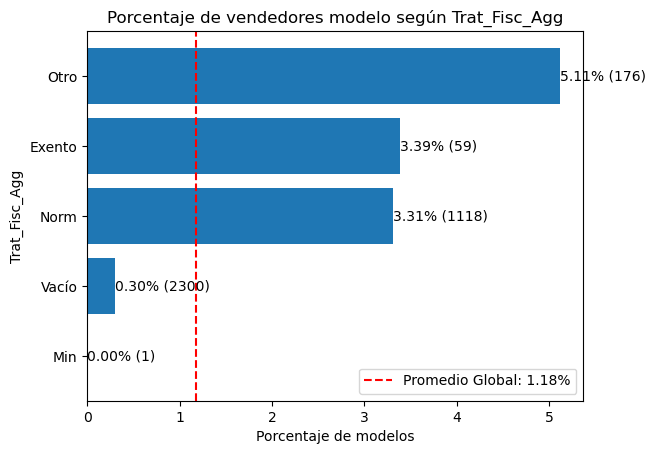

In [110]:
graficar_modelo(ventas_categ, 'Trat_Fisc_Agg')

### `Trat_Fisc` y `Modelo`

In [111]:
checkear_unicidad(ventas_categ, 'Trat_Fisc', 'ID', 'Deposito', 'Subrubro', 'Fecha')

Para algunos ['ID', 'Deposito', 'Subrubro', 'Fecha'] se asignan diferentes valores de Trat_Fisc:
ID    Deposito  Subrubro    Fecha     
2145  9         Miscelaneo  2019-01-01    8
2910  46        Vehiculos   2019-02-01    7
2770  17        Farmacia    2021-09-01    7
2910  46        Vehiculos   2020-02-01    6
                            2019-01-01    6
                                         ..
1381  50        Miscelaneo  2021-05-01    2
                            2021-06-01    2
                            2021-07-01    2
                            2021-08-01    2
3075  31        Farmacia    2020-05-01    2
Name: Trat_Fisc, Length: 12667, dtype: int64


##### Checkear con `Ventas` si hay cierto punto de corte para pasar de una a otra categoría

In [112]:
ventas_prueba = ventas_ipc[['ID', 'Deposito', 'Subrubro', 'Fecha','Ventas','Trat_Fisc']].dropna(subset=['Trat_Fisc']).copy()
duplicados = ventas_prueba[ventas_prueba.duplicated(subset=['ID', 'Deposito', 'Subrubro', 'Fecha'], keep=False)].sort_values(by=['ID', 'Deposito', 'Subrubro', 'Fecha'], ascending=True).copy()
duplicados.groupby('Trat_Fisc')['Ventas'].mean()

Trat_Fisc
0             8.946478e+06
1             5.259615e+06
3             3.460052e+07
Alic.Agrav    4.525596e+07
Alic.Reduc    1.308655e+07
Esp.1         1.070293e+08
Esp.2         8.177575e+07
Esp.3         6.895990e+07
Esp.4         2.298493e+08
Exento        3.671295e+07
MeraComp      7.119958e+07
Min           5.382834e+06
Norm          2.465215e+06
nan           3.572062e+07
Name: Ventas, dtype: float64

Probamos con un caso.

Si resultado es True, significa que, dentro de cada grupo, el valor de 'Ventas' correspondiente a 'Trat_Fisc_Agg' == 0 siempre es mayor que el valor de 'Ventas' correspondiente a 'Trat_Fisc_Agg' == 1. Si resultado es False, significa que al menos en un grupo no se cumple esta condición.

In [113]:
resultado = duplicados.groupby(['ID', 'Deposito', 'Subrubro', 'Fecha']).apply(lambda x: x[x['Trat_Fisc'] == 0]['Ventas'].max() > x[x['Trat_Fisc'] == 1]['Ventas'].min()).all()
resultado

False

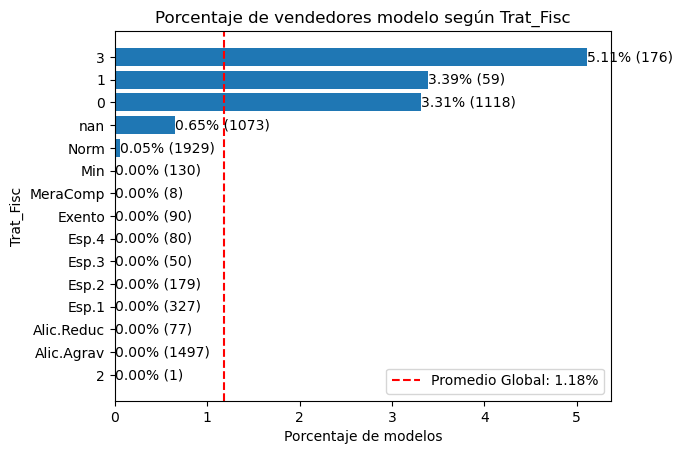

In [114]:
graficar_modelo(ventas_categ, 'Trat_Fisc')

### `Trat_Dif` y `Modelo`

In [115]:
checkear_unicidad(ventas_categ, 'Trat_Dif', 'ID', 'Deposito', 'Subrubro', 'Fecha')

Para cada ['ID', 'Deposito', 'Subrubro', 'Fecha'] solo existe un valor de Trat_Dif.


In [116]:
checkear_unicidad(ventas_categ, 'Trat_Dif', 'ID', 'Deposito', 'Subrubro')

Para algunos ['ID', 'Deposito', 'Subrubro'] se asignan diferentes valores de Trat_Dif:
ID    Deposito  Subrubro     
4     6         Gondola          2
1683  68        Comb. Ley        2
1682  36        Gondola          2
1672  17        Farmacia         2
1669  24        Farmacia         2
                                ..
824   106       Comb. Reventa    2
      70        Comb.            2
      68        Comb. Ley        2
      67        Comb. Ley        2
2978  92        Com. Varios      2
Name: Trat_Dif, Length: 1704, dtype: int64


Se debe a que `Trat_Dif` cambia en el tiempo? O a que hay pocos casos con valores?

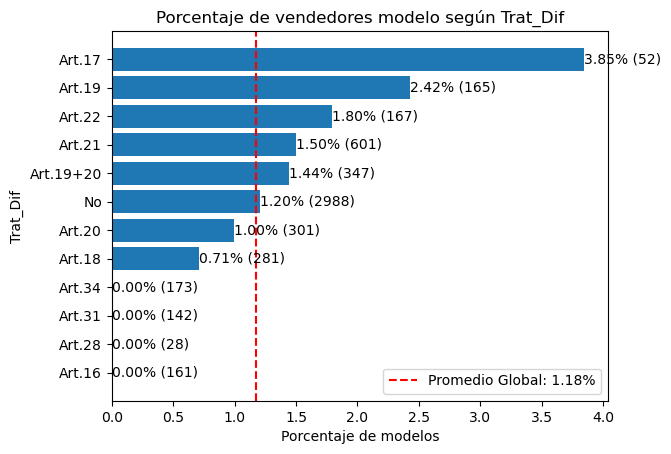

In [117]:
graficar_modelo(ventas_categ, 'Trat_Dif')

### `CM` y `Modelo` (Paso 4)

In [118]:
checkear_unicidad(ventas_categ, 'CM', 'ID')

Para cada ID solo existe un valor de CM.


In [119]:
casos_unicos_cm_1 = ventas_categ[ventas_categ['CM'] == 1]['ID'].nunique()
print("Número de casos únicos de ID para CM = 1:", casos_unicos_cm_1)

Número de casos únicos de ID para CM = 1: 1


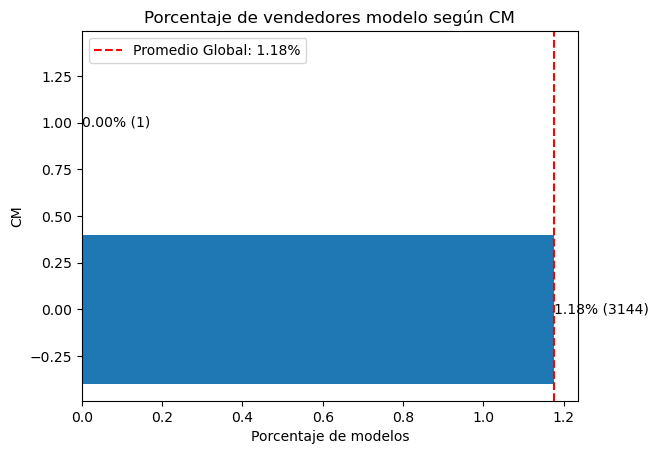

In [120]:
graficar_modelo(ventas_categ, 'CM')

Solo hay un caso que está bajo CM igual a 1 (y no es vendedor modelo). El tamaño de muestra equivale al 0,01% de los casos.

In [121]:
print(f"{round(len(ventas_categ[ventas_categ['CM'] == 1]) / len(ventas_categ) * 100, 2)}%")

0.01%


Se procederá a descartar el caso en un dataset aparte. Y se eliminará la variable `CM`.

In [122]:
#Eliminación de caso CM=1 y columna CM. Y almacenamiento en un dataset aparte

# Se opera sobre el dataset completo

ventas_cm = ventas_ipc[ventas_ipc['CM'] == 1].copy()
ventas_cm.to_csv('../data/interim/tp2_ventas_cm.csv')

ventas_ipc = ventas_ipc[ventas_ipc['CM'] != 1].copy()
ventas_ipc = limpiar_basic(ventas_ipc, 'CM')

# Y luego sobre el dataset de variables categóricas

ventas_categ = ventas_categ[ventas_categ['CM'] != 1].copy()
ventas_categ = limpiar_basic(ventas_categ, 'CM')
ventas_categ

,ID,Omega,Subrubro,Trat_Fisc_Agg,Trat_Fisc,Trat_Dif,Fecha,Deposito,Modelo
0,2133,1,Venta Agrop.,NaN,Norm,No,2019-01-01,7,0
1,1172,1,Venta Agrop.,NaN,nan,No,2019-01-01,7,0
2,2589,1,Vehiculos,NaN,Norm,No,2019-01-01,47,0
3,1907,1,Venta Agrop.,NaN,Norm,No,2019-01-01,5,0
4,1478,1,Venta Agrop.,NaN,nan,No,2019-01-01,7,0
...,...,...,...,...,...,...,...,...,...
378703,815,1,Supermercados,Norm,0,No,2022-06-01,8,0
378704,1098,1,Supermercados,NaN,Alic.Agrav,No,2022-06-01,130,0
378705,1091,1,Supermercados,NaN,Alic.Agrav,No,2022-06-01,130,0
378706,2862,1,Venta Agrop.,NaN,Alic.Agrav,No,2022-06-01,5,0


### Relación entre variables fiscales (`Trat_Fisc` y `Trat_Fisc_Agg` y `Trat_Dif`) (Paso 5)

#### `Trat_Fisc` y `Trat_Fisc_Agg`

Queremos chequear para qué valores de `Trat_Fisc` aparecen valores de `Trat_Fisc_Agg`.

In [123]:
# Este paso lo agrego porque sino el crosstab siguiente no me muestra los NaN
ventas_categ['Trat_Fisc'] = ventas_categ['Trat_Fisc'].fillna('Warning: Relleno')
ventas_categ['Trat_Fisc_Agg'] = ventas_categ['Trat_Fisc_Agg'].fillna('Warning: Relleno')

pd.crosstab(ventas_categ['Trat_Fisc'], ventas_categ['Trat_Fisc_Agg'], dropna=False)

Trat_Fisc_Agg,Exento,Min,Norm,Otro,Warning: Relleno
Trat_Fisc,,,,,
0,0,0,110158,0,0
1,769,0,0,0,0
2,0,1,0,0,0
3,0,0,0,6151,0
Alic.Agrav,0,0,0,0,76566
Alic.Reduc,0,0,0,0,913
Esp.1,0,0,0,0,5383
Esp.2,0,0,0,0,4162
Esp.3,0,0,0,0,621


Al analizar la tabla de contingencia, vemos que los valores de `Trat_Fisc_Agg` sólo aparecen cuando `Trat_Fisc` asume valores 0, 1, 2 ó 3. 
A su vez, hay correspondencia entre 0 y Norm, 1 y Exento, 2 y Min, 3 y Otro. 
¿Se puede unificar todo como `Trat_Fisc`, eliminando entonces `Trat_Fisc_Agg`? ¿Tiene sentido que falte la descripción asociada al tratamiento?

<Axes: xlabel='Trat_Fisc_Agg', ylabel='Trat_Fisc'>

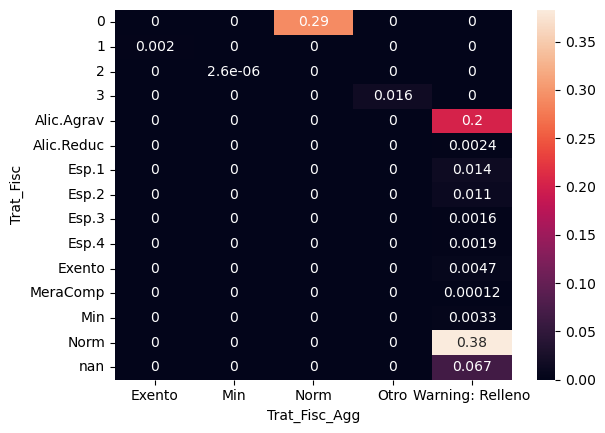

In [124]:
vad = pd.crosstab(ventas_categ['Trat_Fisc'].fillna("Warning: NA"), ventas_categ['Trat_Fisc_Agg'].fillna("Warning: NA"), normalize=True)
sns.heatmap(vad, annot=True)

Vemos que sí existe una gran correlación entre "Norm" de `Trat_Fisc_Agg` y "0" de `Trat_Fisc`.

#### Relación entre `Trat_Fisc` y `Trat_Dif`

Ahora veamos para qué valores de `Trat_Fisc` aparecen valores de `Trat_Dif`. Al analizar la tabla de contingencia vemos que no hay un patrón claro. ¿Podríamos tomar a un dato faltante como "sin tratamiento" o algo por el estilo?

In [125]:
# Este paso lo agrego porque sino el crosstab siguiente no me muestra los NaN
ventas_categ['Trat_Dif'] = ventas_categ['Trat_Dif'].fillna('Waring: Relleno')

pd.crosstab(ventas_categ['Trat_Fisc'], ventas_categ['Trat_Dif'], dropna=False)

Trat_Dif,Art.16,Art.17,Art.18,Art.19,Art.19+20,Art.20,Art.21,Art.22,Art.28,Art.31,Art.34,No
Trat_Fisc,,,,,,,,,,,,
0,813,266,1250,1120,2434,3136,7689,412,167,726,1948,90197
1,0,0,15,48,0,14,162,0,0,1,2,527
2,0,0,0,0,0,0,0,0,0,0,0,1
3,0,119,25,560,1078,80,3220,731,0,2,1,335
Alic.Agrav,608,12,181,62,81,2706,1770,1025,0,56,667,69398
Alic.Reduc,249,0,17,0,9,36,75,1,0,0,36,490
Esp.1,106,81,313,258,185,1087,983,750,74,2,5,1539
Esp.2,1,0,54,0,75,330,1901,1793,0,0,0,8
Esp.3,5,0,13,0,0,551,2,2,0,0,0,48


*   Se concluye que la variable que más información aporta es la de `Trat_Fisc`, superando a `Trat_Fisc_Agg` en que tiene menos valores perdidos. Y a su vez, la información de `Trat_Fisc_Agg` (Exento, Min, Norm, Otro), es capturada por los valores 1, 2, 0, 3 de `Trat_Fisc_Agg`, respectivamente.


*   Respecto a `Trat_Diff`, la misma es superada por `Trat_Fisc` en cuanto a ausencia de valores perdidos. La variable `Trat_Fisc`, en el práctico anterior, había permitido detectar ciertas tendencias de ventas. A su vez que no queda claro el aporte de `Trat_Diff`.


La decisión es droppear `Trat_Fisc_Agg` y `Trat_Dif`

In [126]:
# Se opera sobre el dataset completo
ventas_ipc = limpiar_basic(ventas_ipc, ['Trat_Fisc_Agg', 'Trat_Dif'])

# Y luego sobre el dataset de variables categóricas
ventas_categ = limpiar_basic(ventas_categ, ['Trat_Fisc_Agg', 'Trat_Dif'])
ventas_categ


,ID,Omega,Subrubro,Trat_Fisc,Fecha,Deposito,Modelo
0,2133,1,Venta Agrop.,Norm,2019-01-01,7,0
1,1172,1,Venta Agrop.,nan,2019-01-01,7,0
2,2589,1,Vehiculos,Norm,2019-01-01,47,0
3,1907,1,Venta Agrop.,Norm,2019-01-01,5,0
4,1478,1,Venta Agrop.,nan,2019-01-01,7,0
...,...,...,...,...,...,...,...
378703,815,1,Supermercados,0,2022-06-01,8,0
378704,1098,1,Supermercados,Alic.Agrav,2022-06-01,130,0
378705,1091,1,Supermercados,Alic.Agrav,2022-06-01,130,0
378706,2862,1,Venta Agrop.,Alic.Agrav,2022-06-01,5,0


In [127]:
ventas_ipc.to_csv('../data/interim/tp2_ventas_ipc.csv')
ventas_ipc

,ID,Omega,Subrubro,Trat_Fisc,Fecha,Deposito,Ventas,Alicuota,Comision,Modelo
0,2133,1,Venta Agrop.,Norm,2019-01-01,7,-1.116697e+07,2.00,-2.233394e+05,0
1,1172,1,Venta Agrop.,nan,2019-01-01,7,-5.494877e+06,2.40,-1.318771e+05,0
2,2589,1,Vehiculos,Norm,2019-01-01,47,-2.331939e+06,4.00,-9.327756e+04,0
3,1907,1,Venta Agrop.,Norm,2019-01-01,5,-1.131988e+06,2.00,-2.263974e+04,0
4,1478,1,Venta Agrop.,nan,2019-01-01,7,-4.177637e+05,2.40,-1.002633e+04,0
...,...,...,...,...,...,...,...,...,...,...
378703,815,1,Supermercados,0,2022-06-01,8,1.567422e+09,0.05,7.837112e+07,0
378704,1098,1,Supermercados,Alic.Agrav,2022-06-01,130,1.732460e+09,5.00,8.662302e+07,0
378705,1091,1,Supermercados,Alic.Agrav,2022-06-01,130,2.240194e+09,5.00,1.120097e+08,0
378706,2862,1,Venta Agrop.,Alic.Agrav,2022-06-01,5,2.631098e+09,3.00,7.893293e+07,0


----


## Graficando la serie de tiempo con énfasis en Modelos y Subrubro

### Modelos vs. Tiempo

**Observaciones:**
- Los valores ventas de Modelo son cerca de la mitad de las ventas de no-Modelo
- Durante el confinamiento obligatorio (primera mitad de 2020) las caídas en ventas fueron muy fuertes, pero más fuertes en proporción para vendedores Modelo
- Si la deflación es confiable, parece que los Modelos no han recuperado sus valores de ventas previos a la Pandemia, mientas que los no-Modelo parecen estar levemente por encima

<Axes: xlabel='Fecha', ylabel='Ventas'>

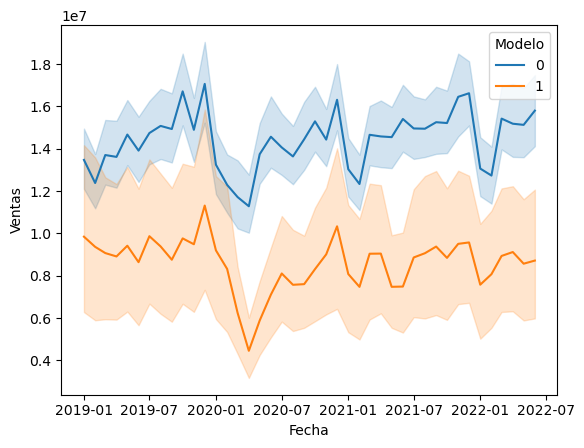

In [173]:
sns.lineplot(x='Fecha', y='Ventas', hue='Modelo', data=ventas_ipc)

### Modelos y Subrubros vs. Tiempo

Visualizamos la diferencia entre Modelo y no-Modelo dentro de cada subrubro. 

**Observaciones:**
- Los valores de venta en Modelos son menores en todos los Subrubros, con la excepción de tres:
    - "Góndola" 
    - "Comb."  
    - "Comb. Ley"


- En los subrubros "Vehículos", "Farmacia" y "Supermercado" los valores de ventas de modelo parecen ser despreciables en comparación con no-Modelo. Tienen valores muy bajos y con muy poca variablidad.

- "Mantenimiento" no parece tener muchos valores Modelo, se podría descartar.

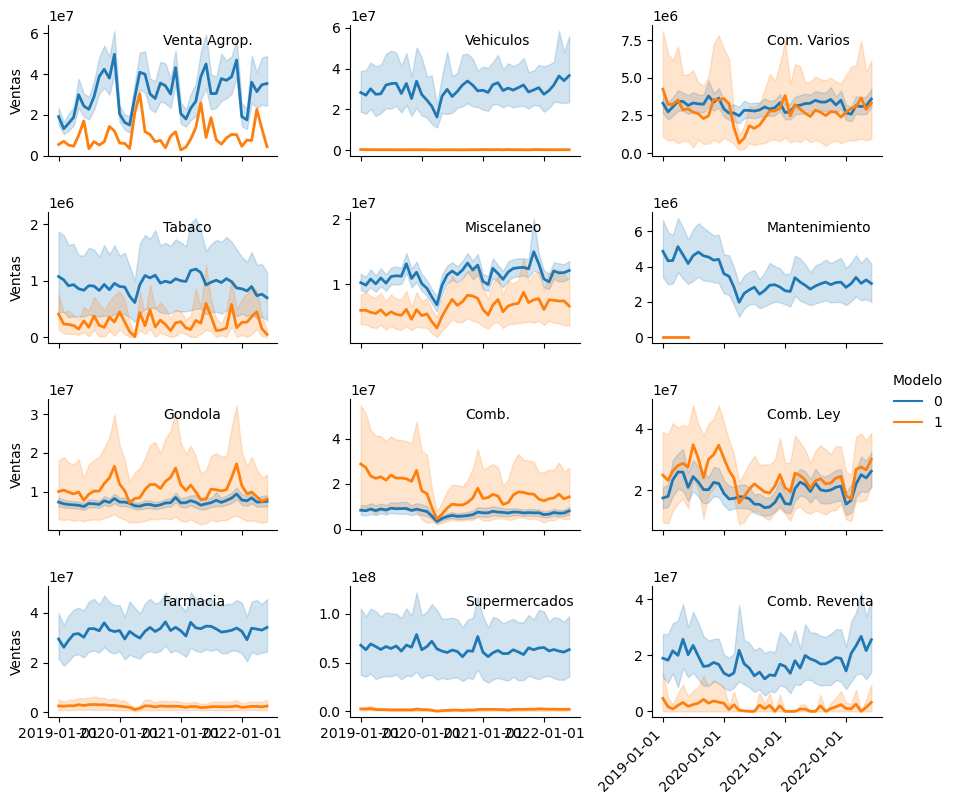

In [188]:
g = sns.relplot(
    data=ventas_ipc,
    x="Fecha", y="Ventas", col="Subrubro", hue="Modelo",
    kind="line", linewidth=2, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=True,
    facet_kws=dict(sharey=False)
)

# Iterate over each subplot to customize further
for subrubro, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.5, .85, subrubro, transform=ax.transAxes)

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xticks(rotation=45, ha='right')

g.set_titles("")
g.set_axis_labels("", "Ventas")    
#g.tight_layout()

In [142]:
ventas_ipc["Ventas"].rolling(3).mean()

0                  NaN
1                  NaN
2        -6.331263e+06
3        -2.986268e+06
4        -1.293897e+06
              ...     
378703    1.426234e+09
378704    1.579432e+09
378705    1.846692e+09
378706    2.201251e+09
378707    3.189517e+09
Name: Ventas, Length: 378666, dtype: float64

Número de IDs con ventas 0 en todo el periodo

In [133]:
np.sum(ventas_ipc.groupby(['ID'])['Ventas'].sum() == 0)

293

Número de IDs-y-Subrubro que tuvieron ventas 0 en el periodo

In [134]:
np.sum(ventas_ipc.groupby(['ID', 'Subrubro'])['Ventas'].sum() == 0)

1141

In [136]:
len(ventas_ipc.groupby(['ID', 'Subrubro'])['Ventas'].sum())

5956